Notebook containing a) parameters and equations to estimate the noise floor of the SP seismometer (for Mars) and the SSP seismometer (for the Moon); and b) spectra of events and noise recorded by the Apollo seismometers. 



## This notebook makes the following figures:

SSP_Noise_Fig5.pdf

SSP_Sensor_Noise.pdf

SP_Mars.pdf



## To run this code, you will need to download data from Geoscope to a local directory 


[ftp://ftpcdd.ipgp.fr/data/XA/](ftp://ftpcdd.ipgp.fr/data/XA/)

Untar all the years eg: 

/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1969


## Sections 

Section 1 - Code

Section 2 - Lowest observed lunar noise 

Section 3 - SSP Sensor Noise Improvements - SSP_Sensor_Noise.pdf

Section 4 - Performance on Mars - SP_Mars.pdf

Section 5 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - SSP_Noise_Fig5.pdf 

Section 6 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Whitepaper version

Section 7 - Target Sensitivity for the Lunar Geophysical Network 

Section 8 - SSP Sensor noise compared with spectra from the Moon and Mars - AGU 2019 elightning talk version

Section 9a - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Comparing vertical and horizontal noise (MHZ, MH1)

Section 9b - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Comparing vertical and horizontal events (MHZ, MH1)

Section 10 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared with noise at each Apollo station

Section 10a - 10th percentile

Section 10b - 90th percentile

Section 10c - 10, 50 and 90th percentile

Section 10d - fill between 10th and 90th percentile

Section 11 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared with noise at each Apollo station (flat response)

Section 12 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Specific noise examples (including flat noise) 

Section 13 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Noise before and after a signal 

Section 14 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared to Lognonné 2020 and Lognonné 2015

Section 15 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Show estimate for the bit noise



# Section 1 - Code 

In [1]:
# The variable ppsd_hours controls how many noise sections are processed. It is used in  plot_lunar_example_ppsd.

# ppsd_hours=1 # use for a test for the noise (will plot just one hour, and no percentile)
# ppsd_hours=6 # short test, will plot percentiles
ppsd_hours=24*28 # final version, takes time to run 

In [2]:
# Run this first
%pylab inline
# plt.rcParams['figure.figsize'] = 10, 4
# plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams.update({"axes.facecolor" : "white",
#                      "axes.edgecolor":  "black"})
# plt.rcParams.update({'font.size': 22})

# defaults
# plt.rcParams['figure.figsize'] = [8.0, 6.0]
# plt.rcParams['figure.dpi'] = 80
# plt.rcParams['savefig.dpi'] = 100

# plt.rcParams['font.size'] = 12
# plt.rcParams['legend.fontsize'] = 'large'
# plt.rcParams['figure.titlesize'] = 'medium'




plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100



plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'

plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.pad'] = 0
plt.rcParams['ytick.major.pad'] = 0
plt.rcParams["legend.handletextpad"] = 0.3

# setting all the dashed lines the same
plt.rcParams['lines.dashed_pattern'] = [3, 1]

from obspy.core.utcdatetime import UTCDateTime
from obspy.signal.spectral_estimation import get_nhnm, get_nlnm
from obspy.signal.filter import envelope
from obspy.core import read, Stream, Trace
from obspy import read_events, read_inventory
from obspy.signal import PPSD
import os.path
import numpy as np
import csv
from obspy import read_events
from matplotlib.patches import Patch
from obspy.clients.fdsn.client import Client, FDSNNoDataException
from scipy.stats import mstats
from datetime import timedelta, date
import pandas as pd
import statistics 
import matplotlib.ticker as ticker

client = Client("IRIS")

Populating the interactive namespace from numpy and matplotlib


In [3]:
# top_level_processed_dir = '/Users/cnunn/lunar_data/PDART_PROCESSED'
inv_name = "files/XA.1969-1977_updated_2019.xml"
inv_name_flat = "files/XA.1969-1977_S12_flat_response.xml"
# To run this code, you will need to download data from Geoscope to a local directory 
# Untar all the years eg: 
# /Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1969
top_level_dir_geoscope = '/Users/cnunn/lunar_data/GEOSCOPE_lunar_data'
top_level_processed_dir = None

In [4]:
# colors for the plots
MUTED_LIGHT_BLUE = 'skyblue'
MUTED_BLUE ='#2E71BA'
MUTED_PINK ='#DE7F94'
MUTED_ORANGE ='#E4A461'
MUTED_DARK_GREEN = '#506356'
MUTED_MID_GREEN = '#6F985F'
MUTED_LIGHT_GREEN = '#C4DD55'
MUTED_PURPLE = '#825D98'
MUTED_DARK_BLUE = '#002078'

In [5]:
def find_processed_dir_geoscope(top_level_dir,year,station,channel='SHZ'):
    return os.path.join(top_level_dir, str(year), station, channel)

# TODO change this elsewhere 
def find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
  stations=['S12','S14','S15','S16'],channel='SHZ'):

    for station in stations: 
        stream = Stream()
        
#         /Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ
# S14.XA..SHZ.1973.317
# S16.XA..*.1973.314
        for date1 in daterange(starttime, endtime):

            dir = find_processed_dir_geoscope(top_level_dir_geoscope,date1.year,station,channel)
            filename = '%s.%s..%s.%s.%s' % (station, 'XA',  channel,
                str(date1.year), str(date1.julday))

            filename = os.path.join(dir,filename)
            print(filename)
            try:
                stream += read(filename)
            except Exception as e:
                print(str(e))

        if len(stream) > 0: 
    #         # print('Before ', stream)
            stream = stream.trim(starttime=starttime,endtime=endtime)
    #         # print('After ', stream)
            stream.merge()

    return stream

In [6]:
def find_dir(top_level_dir,year,station,channel):
    return os.path.join(top_level_dir, str(year), 'XA', station, channel)

def find_processed_dir(top_level_dir,year,station):
    return os.path.join(top_level_dir, str(year), 'XA', station)

def find_seismogram(top_level_dir,starttime,endtime,
  stations=['S12','S14','S15','S16'],channels=['MH1', 'MH2', 'MHZ'], 
  dir_type='pdart_dir',output='ACC'):

    for station in stations: 
        stream = Stream()
        channel='*'
        if dir_type=='processed_dir':
            dir = find_processed_dir(top_level_dir,starttime.year,station)
            filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                str(starttime.year), starttime.julday)
        else:
            dir = find_dir(top_level_dir,starttime.year,station,channel)
            filename = '%s.%s.%s.%s.%s.%03d.gz' % ('XA',station, '*', channel,
                str(starttime.year), starttime.julday)
        filename = os.path.join(dir,filename)
        try:
            stream += read(filename)
        except Exception as e:
            print(str(e))

        if starttime.julday != endtime.julday:
            if dir_type=='processed_dir':
                dir = find_processed_dir(top_level_dir,endtime.year,station)
                filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                    str(endtime.year), endtime.julday)
            else: 
                dir = find_dir(top_level_dir,endtime.year,station,channel)
                filename = '*%s.%s.%s.%s.%s.%03d*.gz' % ('XA',station, '*', channel,
                    str(endtime.year), endtime.julday)
            filename = os.path.join(dir,filename)
            try: 
                stream += read(filename)
            except Exception as e:
                print(str(e))

        # print('Before ', stream)
        stream = stream.trim(starttime=starttime,endtime=endtime)
        # print('After ', stream)

        if stream is not None and len(stream) > 0: 
            for tr in stream: 
                tr.stats.location = ''
                if tr.stats.channel not in channels:
                    stream.remove(tr)

            stream.merge()

    return stream


In [7]:
# Default Values

# Boltzmann constant
k = 1.38E-23 #J/K

flickerCorner = 1

#1. Ebox electronics
#1.1 ADC Noise
fvADC = 0.1 #Hz AD7712 1/f corner
fuADC = 10 #Hz AD7712 noise shaping corner

#1.2 SP FB electronics
DemodGain = 5.61 #FM FB values
DTDrive = 1 #Vrms dummy not used

IntegratorNoiseConstant = 0 # noise at 1 s, worst case value from noise tests

#Rolloff Filter to correct SP psds for transfer function
fro = 1/35
dampf = 1
# SP_VelGain = 25000 # V/(m/s) SP sensitivity
# Low Gain, Lognonne et al, 2019, p69
# SP_VelGain = 9000 # V/(m/s) SP sensitivity
# High Gain, Lognonne et al, 2019, p69
SP_VelGain = 27000 # V/(m/s) SP sensitivity

#Ambient Noise
AmbientAmp = 1E-8
AmbientPwr = 3

#Sensor head electronics
PreAmpGain = 4 #FM FB values 
f_fl = .1 # flicker noise amplitude at 1 Hz
f_rw = 0 # random walk noise amplitude at 1 Hz
f_pow = 0 # Hz Additional noise power law if needed
pow = 4 # power

#Sensor mechanics
temp = 300 # 300 K
DTArea = 2.3 * 23 * 1E-6 # area of DT

#DT noise
noise0 = .1E-6
tau = 0

#Target for the Noise (not currently used)
targetf = [.1,10,40]
targetaccel = [1E-8,1E-8,1.6E-7]
targetRMf = [.01,10]
targetRMaccel = [1E-10,1E-10]

In [8]:
legend_title_M2 = 'SP - Mars'

VNoiseADC_M2 = 1.066E-6 # V/rtHz for AD7712
# voltage noise at 24 V

Q_M2 = 200
# Tom Pike, pers. comm. 

SensorHeadParam_M2 = 34E-9  #(34nV/(Hz**(1/2))
# We use a different calculation for the electronics noise, so this parameter isn't currently used

DTDemodGain_M2 = 2 #MV/m
# We use a different calculation for the electronics noise, so this parameter isn't currently used

f0_M2 = 6 #Hz, Resonant Frequency, from open loop - with spring softening under 1 g
# 6 Hz, from Pike 2016,European Lunar Symposium 2016, also Lognonne 2019

# Should we use a different estimation - using Q? 
# ViscAir_M2 = 18.3E-12 #dynamic viscosity of a vacuum? Pa s

# https://doi.org/10.1073/pnas.0800202105
# dynamic viscosity Earth = 
# η = 1.78 × 10−5 kg/m·s 
# dynamic viscosity Mars = 
# η = 1.3 × 10−5 kg/m·s

ViscAir_M2 = 1.310E-5


DemodTimingError_M2 = 1.75

mass_M2 = .8E-3 #kg
# Tom Pike, pers. comm. (the proof mass had gold bars added to it)

noiseDT0_M2 = 2E-12 #estimate of displacement transducer noise for InSight 
# Tom Pike, pers. comm

# SP design
Q__SP = 200
mass__SP = .8E-3 #kg
noiseDT0__SP = 2E-12 #displacement transducer noise

DTGap_M2 = 10E-6 #effective gap for damping

inVacuum_M2 = False # use code for a vacuum 
withADC_M2 = True # include the ADC noise 


In [9]:
legend_title_L2 ='SSP - Lunar Design'

VNoiseADC_L2 = 1.066E-6/4 # V/rtHz for AD7712
# voltage noise at 24 V

Q_L2 = 100000
# Tom Pike, pers. comm.

SensorHeadParam_L2 = 15E-9  #(34nV/(Hz**(1/2))
# We use a different calculation for the electronics noise, so this parameter isn't currently used
# Reduce SensorHeadParam, better instrument (lower radiation environment) 
# Tom Pike, pers. comm. 

DTDemodGain_L2 = 1 #MV/m
# We use a different calculation for the electronics noise, so this parameter isn't currently used
# Reduce DTDemodGain because we can double the capacitance spacing 
# because we are operating in vacuum.

f0_L2 = 2 #Hz, Resonant Frequency, from open loop - with spring softening under 1 g
# Tom Pike, pers. comm.

# Should we use a different estimation - using Q? 
ViscAir_L2 = 18.3E-12 #dynamic viscosity of a vacuum? Pa s

DemodTimingError_L2 = 1.75

mass_L2 = .8E-3 #kg
# Doubled from 400ng to 800 ng from Pike 2018, IEEE Micro Electro Mechanical Systems

noiseDT0_L2 = noiseDT0_M2/4 #estimate of displacement transducer noise for the Moon
# Tom Pike, pers. comm

# SSP
# Tom Pike, pers. comm. 
Q__SSP = 100000;
mass__SSP = 800E-6 #kg
noiseDT0__SSP = noiseDT0__SP/4 #displacement noise
f0__SSP = 2 #Hz

# we can decrease the capacitance spacing, because we are operating in a near vacuum
# but we do not use this parameter 
DTGap_L2 = None

inVacuum_L2 = True # use code for a vacuum 
withADC_L2 = True # include the ADC noise 



In [10]:
# Box A
def get_noise_floor(f, VNoiseADC, SensorHeadParam, DTDemodGain,f0,ViscAir,
  DemodTimingError,mass,Q,noiseDT0,DTGap,inVacuum=False,withADC=True):
    
    #1. Ebox electronics
    #1.1 ADC Noise
    ADCNoise = VNoiseADC*(1+fvADC/f+f**2/fuADC)**0.5

    #1.2 SP FB electronics
    IntegratorNoise = IntegratorNoiseConstant/(f)

    #Rolloff Filter to correct SP psds for transfer function
    Filt =SP_VelGain* -f**2/(fro**2+1j/dampf*fro*f-f**2)
    ADCAccelNoise = abs(f*ADCNoise/Filt)

    #Sensor head electronics
    AmpNoise = DemodTimingError*SensorHeadParam #Vrms/rtHz, 1.75 for demod timing error
    DTGain = DTDemodGain*1E6/(DemodGain * PreAmpGain) #V/m at preamp

    #Sensor mechanics
    electronicsNoise1 = None
#     
    
    # Estimate thermal noise from Q   
    # Q = 2*np.pi*f0/alpha*mass
#     (Q being taken from the vacuum)
#     THIS ASSUMES A VALUE FOR Q - VACUUM FORMULA 
    if inVacuum: 
        # this is the formula for when operating in a vacuum         
        thermalNoise = np.sqrt(4*k*temp*2*np.pi*f0/Q/mass)*f/f
    else: 
        # when not operating in a vacuum, 
        # suspension noise can be estimated from the area, or from Q  
        alpha = ViscAir*DTArea/DTGap 
        thermalNoise = np.sqrt(4*k*temp*alpha)/mass*f/f
        electronicsNoise1 = (AmpNoise/(DTGain*DTDrive)) * (1+f_fl/f+(f_rw/f)**2 + (f_pow/f)**pow)**0.5*(2*np.pi)**2*abs(f0**2+1j*f0/(mass/alpha)*f-f**2)
    

    #DT noise
#     DTNoise = noise0*abs(1/(1+1j*tau*f))

    #Target for the Noise (not currently used)
    targetf = [.1,10,40]
    targetaccel = [1E-8,1E-8,1.6E-7]
    targetRMf = [.01,10]
    targetRMaccel = [1E-10,1E-10]
#     there also seeems to be 2 ways to calculate the electronics noise


    print('flickerCorner=', flickerCorner)
    noiseDT = noiseDT0*np.sqrt(1 + flickerCorner/f)
    alpha2 = 2*np.pi*f0/Q*mass
    T = (2*np.pi)**2*abs(f0**2+1j*f0/(mass/alpha2)*f-f**2)
    total_noiseDT = noiseDT*T
#     not completely sure these are equivalent:
    electronicsNoise2 = total_noiseDT

    IntegratorNoise = IntegratorNoiseConstant/(f)
    if withADC:
        FMNoiseModel = (electronicsNoise2**2 + IntegratorNoise**2 + thermalNoise**2 + ADCAccelNoise**2)**.5
    else:
        # for the lunar design, the ADC noise is negligible 
        FMNoiseModel = (electronicsNoise2**2 + IntegratorNoise**2 + thermalNoise**2)**.5
        
    return (electronicsNoise1, electronicsNoise2, ADCAccelNoise, thermalNoise, FMNoiseModel)

In [11]:
def simple_deglitch(data, min=-30., max=30):
    l_before = len(data)
    if np.ma.isMaskedArray(data):
        data = np.ma.MaskedArray.filled(data, 999)
    df = pd.DataFrame(data=data,columns=['data'])
    df.drop(df[df['data'] < min].index, inplace = True) 
    df.drop(df[df['data'] > max].index, inplace = True) 
    df.drop(df[df['data'] == 999].index, inplace = True) 
    arr = df['data'].to_numpy()
    l_after = len(arr)

    if l_after < l_before:
        print('Initial no. of samples: {}, Final no. of samples: {}'.format(l_before,l_after))
    return arr

In [12]:
# test simple_deglitch
arr = np.array([110, 0, 1, 1, 0, 1, 0, 1, 3, 0, -110, 0, 0])
print(simple_deglitch(arr))

m_arr = np.ma.array([1, 1, 0, 0, 0, 0], mask=[0, 0, 1, 1, 1, 0])
print(simple_deglitch(m_arr))

m_arr = np.ma.array([1, 1, 0, 0, 0, 0], mask=[1, 1, 1, 1, 1, 1])
print(simple_deglitch(m_arr))

Initial no. of samples: 13, Final no. of samples: 11
[0 1 1 0 1 0 1 3 0 0 0]
Initial no. of samples: 6, Final no. of samples: 3
[1 1 0]
Initial no. of samples: 6, Final no. of samples: 0
[]


In [13]:
# Viewing signals and noise (before and after the signal) 

def plot_before_and_after(top_level_dir,dir_type,inv_name,seismograms=[],sp_seismograms=[],
                            xlim=(0.001,100), ylim=(1e-11,1e-5),
                            title='Signal and Noise',
                            figname='plots/signal_and_noise.pdf'):
    
    plt.rcParams['figure.figsize'] = 10, 10
    
    fig, ax1 = plt.subplots()
        
    # read the response file
    inv = read_inventory(inv_name)
        
    for i, seismogram in enumerate(seismograms):

        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        color = seismogram[3]

        label = seismogram[4]
        linestyle = seismogram[5]
        
        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
#          this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,1000),
                       db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label, color=color, linestyle=linestyle)
        
#        NOISE from 1 hour before 
        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0]) - 3600
        # first 10 mins 
        endtime = starttime + 600.
        
        #  this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,1000),
                       db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label+' - 1 hour before', color=color, linestyle='dotted')
        
        
        #        NOISE from 1 hour after 
        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0]) + 3600
        # first 10 mins 
        endtime = starttime + 600.
        
        #  this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,1000),
                       db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label+' - 1 hour after', color=color, linestyle='dashed')
        
    for i, seismogram in enumerate(sp_seismograms):
        # these seismograms start at energy onset
        starttime = seismogram[0]
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        color = seismogram[3]

        label = seismogram[4]
        linestyle = seismogram[5]

        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code])

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)     
    
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.0833,20),
                       db_bins=(-200, -50, 1.))
        
        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label, color=color, linestyle='solid')
        
        
#         1 hour before 
        starttime = seismogram[0] - 3600
        # first 10 mins 
        endtime = starttime + 600.
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code])

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)     
    
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.0833,20),
                       db_bins=(-200, -50, 1.))
        
        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label+' - 1 hour before', color=color, linestyle='dotted')

        
        #         1 hour after 
        starttime = seismogram[0] + 3600
        # first 10 mins 
        endtime = starttime + 600.
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code])

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)     
    
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.0833,20),
                       db_bins=(-200, -50, 1.))
        
        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=2, label=label+' - 1 hour after', color=color, linestyle='dashed')

   


#     if xaxis_frequency:
    plt.xlim(xlim)
#     plt.xlabel('Frequency [Hz]',fontsize=16)
    plt.xlabel('Frequency [Hz]')
#     else:
#         plt.xlim(0.01,1000)
#         plt.xlabel('Periods [s]')
#     if yaxis_db:    
#         # TODO are the units on yaxis correct?
#         print('Are the units on yaxis correct?')
#         plt.ylabel('Amplitude [$m^2/s^4/Hz$] [dB]')
#     else:
    plt.ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ]',fontsize=16)
    plt.yscale('log')

    ax1.grid(b=True, which='major', color='gray', linestyle='solid')
    ax1.grid(b=True, which='minor', color='lightgray', linestyle='solid')

    plt.xscale('log')
    ax1.set_ylim(ylim)

    ylim1, ylim2 = ax1.get_ylim()


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(np.log10(ylim1)*20, np.log10(ylim2)*20)  
    ax2.grid(False)               

    ax2.set_ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ] [dB]', color=MUTED_DARK_BLUE, fontsize=16)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=MUTED_DARK_BLUE, labelsize=12)
    
    ax1.legend(loc='upper left', framealpha=1, handlelength=4, fontsize=12) 
    ax1.tick_params(axis='both', labelsize=12)

    # ask matplotlib for the plotted objects and their labels
#         lines, labels = ax1.get_legend_handles_labels()
#         ax2.legend(lines, labels, loc='upper left', framealpha=1)

    plt.title(title, fontsize=16)
#     ax1.title.set_fontsize(12)
    plt.tight_layout()
    plt.savefig(figname)
    plt.show()


In [14]:
def daterange(starttime, endtime):
    starttime = UTCDateTime(year=starttime.year, julday=starttime.julday)
    for n in range(int((endtime - starttime)/(24*3600))+1 ):
        yield starttime + timedelta(n)

In [15]:
# test daterange function
for x in daterange(UTCDateTime('1973-11-10T01:00'), UTCDateTime('1973-11-11T23:59')):
    print(x)

1973-11-10T00:00:00.000000Z
1973-11-11T00:00:00.000000Z


In [16]:


def plot_lunar_example_ppsd(top_level_dir,dir_type,inv_name,inv_name_flat=None,seismograms=[],sp_seismograms=[],
                            noise_seismograms=[],sp_noise_seismograms=[],
                            flat_seismograms=[],flat_noise_seismograms=[],
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=False,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=False,low_moon_noise_color='slategray',
                            show_bit_noise=False,bit_noise_color='red',sp_bit_noise_color='orange', flat_bit_noise_color='#800020',
                            show_lognonne=False, 
                            noise_periods=[], fill_between=False,
                            xlim=(0.001,100), ylim=(1e-11,1e-5),
                            withADC=True,
                            title='Target Sensitivity for the Lunar Geophysical Network',
                            figname='plots/fig.pdf',figsize=(6,6)):
    
    
    
#     instrument designs and targets 
#     show_vbb_target
#     show_sp_mars 
#     show_sp_lunar_target 
#     show_silicon_audio_target 
#     show_LGN_target 
    
#     observations 
#     show_Mars_noise_SP 
#     show_Mars_noise_VBB 
#     show_Mars_cruise 

#     show_low_moon_noise
    
    # frequencies for the calculated plots 
    f_spectral_plot = np.logspace(-4, 2, num=300)
    
    fig, ax1 = plt.subplots(figsize=figsize)
    
    plt.rcParams['font.size'] = 8
    
    # read the response file
    inv = read_inventory(inv_name)
    
    if inv_name_flat is not None:
        inv_flat = read_inventory(inv_name_flat)
    
    if show_vbb_target:
    
        with open('files/fvbb.csv', mode='r') as csv_file:
            readCSV = csv.reader(csv_file, delimiter=',')
            for rows in readCSV:
                pass
            fvbb = np.float_(rows)  

        with open('files/bruit_entree_vit2.csv', mode='r') as csv_file:
            readCSV = csv.reader(csv_file, delimiter=',')
            for rows in readCSV:
                bruit_entree_vit2 = np.float_(rows)  

        # VBB  Target  
        plt.plot(fvbb,bruit_entree_vit2,linewidth=2,
              color=vbb_target_color, linestyle='dashed', label='VBB (predicted)')  

        
    if show_sp_mars: 
        # Mars (current) 
        withADC = False
        _, _, _, _, FMNoiseModel_M2 = (get_noise_floor(
          VNoiseADC=VNoiseADC_M2,
          f=f_spectral_plot, SensorHeadParam=SensorHeadParam_M2,
          DTDemodGain=DTDemodGain_M2,f0=f0_M2,ViscAir=ViscAir_M2,
          DemodTimingError=DemodTimingError_M2,mass=mass_M2,Q=Q_M2,
          noiseDT0=noiseDT0_M2,DTGap=DTGap_M2,inVacuum=inVacuum_M2,withADC=withADC_M2))
        
        plt.loglog(f_spectral_plot,FMNoiseModel_M2,color=sp_mars_color,linewidth=2,label=legend_title_M2,linestyle='solid')

    if show_sp_lunar_target:
        
        # Note that we didn't include the ADC noise in the total plot for AGU 2019 elightning talk - SSP_Noise_AGU.pdf
        # we decided to change this for the paper (the paper also has a lower value for the 
        # voltage noise on the ADC - VNoiseADC)      
        # Lunar Design
        _, _, _, _, FMNoiseModel_L2 = (get_noise_floor(
          VNoiseADC=VNoiseADC_L2,
          f=f_spectral_plot, SensorHeadParam=SensorHeadParam_L2,
          DTDemodGain=DTDemodGain_L2,f0=f0_L2,ViscAir=ViscAir_L2,
          DemodTimingError=DemodTimingError_L2,mass=mass_L2,Q=Q_L2, noiseDT0=noiseDT0_L2,DTGap=DTGap_L2,withADC=withADC,inVacuum=True))

        plt.loglog(f_spectral_plot,FMNoiseModel_L2,color=sp_lunar_target_color,linewidth=3,label='SSP (predicted)',linestyle='dashed')
        
    # Silicon Audio Target  
    if show_silicon_audio_target: 
        sia_freq = []
        sia_noise = []

        # read in the projected noise curve         
        with open('files/SiA_DALI_projected_noise.txt', mode='r',newline='\n') as csv_file:
            readCSV = csv.reader(csv_file, delimiter=',')
            next(readCSV)
            for row in readCSV:
                sia_freq.append(float(row[0]))
                sia_noise.append(float(row[1]))
                
        plt.plot(sia_freq,sia_noise,linewidth=2,
              color=silicon_audio_target_color, linestyle='dashed', label='SiliconAudio (predicted)')  

    if show_LGN_target:
        noise_targets=[
            [0.01, 1, 3e-11, 'LGN (target)', LGN_target_color],
            ]
        for noise_target in noise_targets: 
            plt.plot([noise_target[0],noise_target[1]], [noise_target[2],noise_target[2]], 
                 color=noise_target[4], linewidth=2, 
                 label=noise_target[3])

    if show_Mars_noise_SP:
        
        stNoise = None
        # this is a particularly low noise period
        t1 = UTCDateTime('2019-03-01T15:01:49.423000Z')
        t2 = t1 + 200
        try:
            
            # this stationxml file was originally from the full xml file: stationxml.xb.elyse.2019.333.sxml
            # with just the HHU and EHU channels to keep the file small            
            invNoise = read_inventory('files/stationxml.xb.elyse.2019.333_HHU_EHU.sxml')
            invNoise_EHU=invNoise.select(channel='EHU')

            stNoise_sel = client.get_waveforms("XB", "ELYSE", "65", "EHU", t1, t2)
            nyquist = (stNoise_sel[0].stats.sampling_rate)/2
            stNoise_sel.detrend()
            ppsd = PPSD(stNoise_sel[0].stats, metadata=invNoise_EHU, ppsd_length=200.0,
                   skip_on_gaps=True, period_limits=(1/nyquist, 33),
                   db_bins=(-250, -50, 1))
            ppsd.add(stNoise_sel[0])
            (noise_pbc, noise_mode) = ppsd.get_mode()

            xdata = 1.0 / noise_pbc
            # rotating didn't work, because PPSD needs components with the same 
            # orientation as the data
            # # short.rotate(method="->ZNE", inventory=inv, components=("UVW"))
            # go to physical units from dB
            ydata = 10**(noise_mode/20.)

            plt.plot(xdata, ydata, linewidth=2, label='SP Low Noise Mars', color=Mars_noise_SP_color, zorder=5)
            
        except FDSNNoDataException as e:
            print(e)
              
    

    if show_Mars_cruise:

        # files from cruise are in the files directory            
        cruise_inv_name = "files/CRUI1.xml"
        cruise_data = "files/CRUI1-2.mseed"
        
        invEHc = read_inventory(cruise_inv_name)

        stEHc = read(cruise_data)
        stEHc_sel = stEHc.select(channel='EHW')
        stEHc_sel.split()
#         stEHc_sel.attach_response(invEHc)

        # The fourth trace has a nice low noise segment
        # (some of the others contain calibration pulses)
        trc = stEHc_sel[4]
        
        nyquist = (trc.stats.sampling_rate)/2

        trc.detrend()
        ppsd = PPSD(trc.stats, metadata=invEHc, ppsd_length=200.0,
                       skip_on_gaps=True, period_limits=(1/nyquist, 10),
                       db_bins=(-200, -50, 1))
        ppsd.add(trc)
        (cruise_pbc, cruise_mode) = ppsd.get_mode()
        
        xdata = 1.0 / cruise_pbc
        # go to physical units from dB
        ydata = 10**(cruise_mode/20.)
        
        plt.plot(xdata, ydata, linewidth=2, label='SP Cruise to Mars', color=Mars_cruise_color, zorder=5)
        
    if show_Mars_noise_VBB:
        
        stNoise = None
        # this is a particularly low noise period
        t1 = UTCDateTime('2019-03-01T15:01:49.423000Z')
        t2 = t1 + 200
        try:
            
            # this stationxml file was originally from the full xml file: stationxml.xb.elyse.2019.333.sxml
            # with just the HHU and EHU channels to keep the file small            
            invNoise = read_inventory('files/stationxml.xb.elyse.2019.333_HHU_EHU.sxml')
            invNoise_HHU=invNoise.select(channel='HHU')
            
            stNoise_sel = client.get_waveforms("XB", "ELYSE", "00", "HHU", t1, t2)
            nyquist = (stNoise_sel[0].stats.sampling_rate)/2
            stNoise_sel.detrend()
            ppsd = PPSD(stNoise_sel[0].stats, metadata=invNoise_HHU, ppsd_length=200.0,
                   skip_on_gaps=True, period_limits=(1/nyquist, 33),
                   db_bins=(-250, -50, 1))
            ppsd.add(stNoise_sel[0])
            (noise_pbc, noise_mode) = ppsd.get_mode()

            xdata = 1.0 / noise_pbc
            # rotating didn't work, because PPSD needs components with the same 
            # orientation as the data
            # # short.rotate(method="->ZNE", inventory=inv, components=("UVW"))
            # go to physical units from dB
            ydata = 10**(noise_mode/20.)

            plt.plot(xdata, ydata, linewidth=2, label='VBB Low Noise Mars', color=Mars_noise_VBB_color)

        except FDSNNoDataException as e:
            print(e)     

    if show_bit_noise:
        for x in range(0,99):
            tr = Trace()
            tr.stats.network = 'XA'
            tr.stats.station = 'S12'
            tr.stats.channel = 'MHZ'
            tr.stats.starttime = UTCDateTime('1973-03-13T08:00:59.997428Z')
            tr.stats.sampling_rate = 6.625
            tr.stats.calib = 1.0
            tr.data = 0.9 + randint(0, 2, 3976)
            
#             random.random()
            
            tr.data = tr.data.round()
            
            # remove the mean? 
            mean = tr.data.mean()

            stream = Stream()
            stream.append(tr)
        
            ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600.,
                           skip_on_gaps=True,period_limits=(0.3,1000),
                           db_bins=(-200, -50, 0.1))

            ppsd.add(stream)

            (seismogram_pbc, seismogram_mode) = ppsd.get_mode()

            xdata = 1.0 / seismogram_pbc
            # go to physical units from dB
            ydata = 10**(seismogram_mode/20.)

            if x == 0:
                label = 'Digitizer Noise'
            else:
                label = None

            plt.plot(xdata, ydata, linewidth=1.5, color=bit_noise_color, linestyle='solid', label=label)
            
        for x in range(0,99):
            tr = Trace()
            tr.stats.network = 'XA'
            tr.stats.station = 'S14'
            tr.stats.channel = 'SHZ'
            tr.stats.starttime = UTCDateTime('1971-04-17T07:03:59.991103Z')
            tr.stats.sampling_rate = 48.03125
            tr.stats.calib = 1.0
            tr.data = randint(0, 2, 28820)
            stream = Stream()
            stream.append(tr)

            ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                           skip_on_gaps=False,period_limits=(0.3,1000),
                           db_bins=(-200, -50, 1.))

            ppsd.add(stream)

            (seismogram_pbc, seismogram_mode) = ppsd.get_mode()

            xdata = 1.0 / seismogram_pbc
            # go to physical units from dB
            ydata = 10**(seismogram_mode/20.)

            if x == 0:
                label = 'Digitizer Noise (SP)'
            else:
                label = None

            plt.plot(xdata, ydata, linewidth=1.5, color=sp_bit_noise_color, linestyle='solid', label=label)
            
        for x in range(0,99):
            tr = Trace()
            tr.stats.network = 'XA'

            tr.stats.channel = 'MHZ'
            # pick a time during flat operations   
            tr.stats.starttime = UTCDateTime('1974-10-17T00:00:00.000Z')
            tr.stats.station = 'S12'


            
            tr.stats.sampling_rate = 6.625
            tr.stats.calib = 1.0
            tr.data = randint(0, 2, 39760)
            stream = Stream()
            stream.append(tr)


            ppsd = PPSD(stream[0].stats, metadata=inv_flat, ppsd_length=6000,
                           skip_on_gaps=False,period_limits=(0.3,1000),
                           db_bins=(-220, -50, 0.1))

            ppsd.add(stream)

            (seismogram_pbc, seismogram_mode) = ppsd.get_mode()

            xdata = 1.0 / seismogram_pbc
            # go to physical units from dB
            ydata = 10**(seismogram_mode/20.)

            if x == 0:
                label = 'Digitizer Noise (Flat)'
            else:
                label = None

            plt.plot(xdata, ydata, linewidth=1.5, color=flat_bit_noise_color, linestyle='solid', label=label)
         
    if show_lognonne: 
        x, y = zip(*lognonne_Apollo_noise_2020)
        plt.plot(x, y, color='black', linewidth=2,label='Lognonne Moon Noise 2020',linestyle='dashed', zorder=10)

        x, y = zip(*lognonne_2015_SP)
        plt.plot(x, y, color='purple', linewidth=2,label='Lognonne 2015 SP',linestyle='dashed', zorder=10)

        x, y = zip(*lognonne_2015_LP_Peaked)
        plt.plot(x, y, color='hotpink', linewidth=2,label='Lognonne 2015 Peaked',linestyle='dashed', zorder=10)

       
            
#                      network: XA
#          station: S14
#         location: 
#          channel: SHZ
#        starttime: 1971-04-17T07:03:59.991103Z
#          endtime: 1971-04-17T07:13:59.996308Z
#    sampling_rate: 48.03125
#            delta: 0.02081977878985036
#             npts: 28820
#            calib: 1.0
#          _format: MSEED
#            mseed: AttribDict({'dataquality': 'D', 'number_of_records': 162, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 2592768})
        
    for i, seismogram in enumerate(seismograms):

        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        color = seismogram[3]

        label = seismogram[4]
        linestyle = seismogram[5]
        
        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
        #  this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean


        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,100),
                       db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=1.5, color=color, linestyle=linestyle, zorder=5)
        
        #  repeat, with just the bit which is properly filtered         
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
               skip_on_gaps=False,period_limits=(1.1,3.3),
               db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        plt.plot(xdata, ydata, linewidth=4, label=label, color=color, linestyle=linestyle, zorder=5)
        
    for i, seismogram in enumerate(sp_seismograms):
        # these seismograms start at energy onset
        starttime = seismogram[0]
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        color = seismogram[3]

        label = seismogram[4]
        linestyle = seismogram[5]

        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code])

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)     
    
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.0833,3),
                       db_bins=(-200, -50, 1.))
        
        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=1, color=color, linestyle=linestyle, zorder=5)
   
        #  repeat, with just the bit which is properly filtered         
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
               skip_on_gaps=False,period_limits=(0.2,1),
               db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        plt.plot(xdata, ydata, linewidth=4, label=label, color=color, linestyle=linestyle, zorder=5) 

    for i, seismogram in enumerate(flat_seismograms):
        

        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        color = seismogram[3]

        label = seismogram[4]
        linestyle = seismogram[5]
        
        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
        #  this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean


        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv_flat, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,2000),
                       db_bins=(-220, -50, 0.1))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=1.5, color=color, linestyle=linestyle, zorder=3)
            
        #  repeat, with just the bit which is properly filtered         
        ppsd = PPSD(stream[0].stats, metadata=inv_flat, ppsd_length=600,
               skip_on_gaps=False,period_limits=(1,1000),
               db_bins=(-220, -50, 0.1))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        plt.plot(xdata, ydata, linewidth=4, label=label, color=color, linestyle=linestyle, zorder=3)


    for i, seismogram in enumerate(noise_seismograms):
        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        
        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
#         this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.3,1000),
                       db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=1, color=MUTED_BLUE, linestyle='dotted',zorder=3)
        
            
        #  repeat, with just the bit which is properly filtered         
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
               skip_on_gaps=False,period_limits=(1.1,3.3),
               db_bins=(-200, -50, 1.))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        if i == 0:
            label = 'Apollo Noise'
        else:
            label = None
        
        plt.plot(xdata, ydata, linewidth=1, label=label, color=MUTED_BLUE, linestyle='solid',zorder=3)
  
    
    for i, seismogram in enumerate(sp_noise_seismograms):
        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        
    
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code])

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)     
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(0.0833,20),
                       db_bins=(-200, -50, 1.))
        
        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        if i == 0:
            label = 'Apollo Noise (SP)'
        else:
            label = None
        

        
        plt.plot(xdata, ydata, linewidth=1, color=MUTED_LIGHT_BLUE, linestyle=linestyle, zorder=3)
            
        #  repeat, with just the bit which is properly filtered         
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=600,
               skip_on_gaps=False,period_limits=(1/5,1),
               db_bins=(-200, -50, 1.))

        ppsd.add(stream)
        
        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
              
        plt.plot(xdata, ydata, linewidth=1, color=MUTED_LIGHT_BLUE, linestyle=linestyle, label=label, zorder=3)
        
    for i, seismogram in enumerate(flat_noise_seismograms):
    
        # these seismograms start at energy onset
        starttime = UTCDateTime(seismogram[0])
        
        print(starttime)
        # first 10 mins 
        endtime = starttime + 600.
        station_code = seismogram[1]
        channel = seismogram[2]
        
        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
#         this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            mean = tr.data.mean()
            tr.data = tr.data - mean

        # split the stream, then refill it with zeros on the gaps
        stream = stream.split()
        stream = stream.merge(fill_value=0)

        ppsd = PPSD(stream[0].stats, metadata=inv_flat, ppsd_length=600,
                       skip_on_gaps=False,period_limits=(1,1000),
                       db_bins=(-220, -50, 0.1))

        ppsd.add(stream)

        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)

        plt.plot(xdata, ydata, linewidth=1, color=MUTED_DARK_BLUE, linestyle='dotted',zorder=2)

    
        
        if i == 0:
            label = 'Apollo Noise (Flat)'
        else:
            label = None
            
        #  repeat, with just the bit which is properly filtered                
        ppsd = PPSD(stream[0].stats, metadata=inv_flat, ppsd_length=600,
               skip_on_gaps=False,period_limits=(1/0.3, 1/0.02),
               db_bins=(-220, -50, 0.1))

        ppsd.add(stream)
            
        (seismogram_pbc, seismogram_mode) = ppsd.get_mode()
        
        xdata = 1.0 / seismogram_pbc
        # go to physical units from dB
        ydata = 10**(seismogram_mode/20.)
        
        plt.plot(xdata, ydata, linewidth=1, label=label, color=MUTED_DARK_BLUE, linestyle='solid',zorder=2)


    if len(noise_periods) > 0:
        deglitch=True
        print('Using simple_deglitch() for the noise periods')
    
    for i, noise_period in enumerate(noise_periods):
        starttime = noise_period['starttime']
        station_code = noise_period['station_code']  
        channel = noise_period['channel']
        color = noise_period['color']  
        label = noise_period['label']
        linestyle = noise_period['linestyle']  
        period_limits = noise_period['period_limits']
        db_bins = noise_period['db_bins']  
        starttime = noise_period['starttime']
        ppsd_length = noise_period['ppsd_length']  
        starttime = noise_period['starttime']
        ppsd_hours = noise_period['ppsd_hours'] 
        dominant_period = noise_period['dominant_period']
        percentiles = noise_period['percentiles']
        percentile_labels = noise_period['percentile_labels']  
        starttime = noise_period['starttime']
        label_pos = noise_period['label_pos']  
        linewidth = noise_period['linewidth']  
 
        # total time to process           
        endtime = starttime + 3600.*ppsd_hours

        # this uses my SEED inport 
#         stream = find_seismogram(top_level_dir,starttime,endtime,
#           stations=[station_code],channels=[channel],dir_type=dir_type)
      
        #  this uses the GEOSCOPE data 
        stream = find_seismogram_geoscope(top_level_dir_geoscope,starttime,endtime,
          stations=[station_code],channel=channel)

        # remove the mean? 
        for tr in stream:
            
            mean = tr.data.mean()
            tr.data = tr.data - mean
        
            if deglitch:
                # use simple deglitch to remove the majority of the numerical glitches             
                tr.data = simple_deglitch(tr.data, min=-30,max=30)
            
            if tr.stats.channel == 'MHN':
                tr.stats.channel = 'MH1'
            elif tr.stats.channel == 'MHE':
                tr.stats.channel = 'MH2'             
                
#         # split the stream, then refill it with zeros on the gaps
#         stream = stream.split()
#         stream = stream.merge(fill_value=0)

        # calculate the PPSD -it's important to use skip_on_gaps=True for the noise segments,
        # otherwise you can get segments without any noise at all       
        
        ppsd = PPSD(stream[0].stats, metadata=inv, ppsd_length=ppsd_length,
                       skip_on_gaps=True,period_limits=period_limits,
                       db_bins=db_bins)
        
        
        if len(stream) == 0: 
            print('continuing with the next one')
            continue
            
        changed = ppsd.add(stream)
        if changed == False:
            print('Nothing to add')
            continue
            
        print('Count of psd segments ', ppsd.current_histogram_count)
        print(label,dominant_period)
        
        if fill_between:
            # get percentiles         
            (seismogram_pbc1, seismogram_mode1) = ppsd.get_percentile(percentiles[0])

            xdata1 = 1.0 / seismogram_pbc1
            # go to physical units from dB
            ydata1 = 10**(seismogram_mode1/20.)
            
            (seismogram_pbc2, seismogram_mode2) = ppsd.get_percentile(percentiles[1])

            # go to physical units from dB
            ydata2 = 10**(seismogram_mode2/20.)
            
            plt.fill_between(xdata1, ydata1, ydata2,color=color,label=label,alpha=0.5)
            plt.plot(xdata1, ydata1, linewidth=1, color=color, linestyle='solid',zorder=5)
            plt.plot(xdata1, ydata2, linewidth=1, color=color, linestyle='solid',zorder=5)

        else:
    
            for percentile in percentiles:

                # get percentiles         
                (seismogram_pbc, seismogram_mode) = ppsd.get_percentile(percentile)

                # find the index of the first period over the dominant period            
                i_2 = np.min(np.argwhere(seismogram_pbc > dominant_period))

                print('{}% {}'.format(percentile,seismogram_mode[i_2]))

                xdata = 1.0 / seismogram_pbc
                # go to physical units from dB
                ydata = 10**(seismogram_mode/20.)

                plt.plot(xdata, ydata, linewidth=linewidth, color=color, linestyle=linestyle, label=label,zorder=2)

                if percentile_labels is not None and percentile in percentile_labels: 

                     # find the index of the first period over the label_pos           
                    i_3 = np.min(np.argwhere(seismogram_pbc > 1/label_pos))

                    t = plt.gca().text(
                     label_pos, ydata[i_3], percentile, ha='center', va='center', rotation=0, zorder=30,
                     bbox=dict(boxstyle='circle,pad=0.2', fc='white', ec=color, lw=2))

                label = None
    
    label='Low Earth Noise'
    from obspy.signal.spectral_estimation import get_nhnm, get_nlnm
#     for periods, noise_model in get_nhnm(), get_nlnm():
    periods, noise_model = get_nlnm()

    xdata = 1.0 / periods
    # go to physical units from dB
    ydata = 10**(noise_model/20.)

    plt.plot(xdata, ydata, '0.4', linewidth=1,
      color='slategray', label=label, zorder=2)

    if show_low_moon_noise: 
        x, y = zip(*moon_low_noise)
        plt.plot(x, y, color=low_moon_noise_color, linewidth=3,label='Low Moon Noise',linestyle='dashed',zorder=10)

    plt.xlim(xlim)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ]')
    plt.yscale('log')

    ax1.grid(b=True, which='minor', color='lightgray', linestyle='solid')
    ax1.grid(b=True, which='major', color='gray', linestyle='solid')

    plt.xscale('log')
    ax1.set_ylim(ylim)

    ylim1, ylim2 = ax1.get_ylim()


    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(np.log10(ylim1)*20, np.log10(ylim2)*20)  
    
    tick_spacing = 10
    ax2.grid(False)    

    ax2.set_ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ] [dB]', color=MUTED_DARK_BLUE)# we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=MUTED_DARK_BLUE, pad=2)
    leg = ax1.legend(loc='upper left', framealpha=1, handlelength=2)
    # had some problems with different length dashes, so setting all the linewidths in the legend to the same value    
    for lin in leg.get_lines():
        lin.set_linewidth(2)

    ax2.yaxis.set_major_locator(ticker.MultipleLocator(20))   

    plt.title(title)
    fig.tight_layout()
    plt.savefig(figname)
    plt.show()

In [17]:
# Produce the SSP_Sensor_Noise.pdf figure which plots each of the noise components, 
# and the improvements between Mars and the Moon
def plot_seismometer_improvements():

    # frequencies
    f = np.logspace(-4, 2, num=300)

#   14 cm wide figure
    fig = plt.figure(figsize=(5.51, 5.51*1.1))
    ax = fig.add_subplot(111)
    
    print(legend_title_M2, 
          'VNoiseADC=', VNoiseADC_M2, 
          'SensorHeadParam=' , SensorHeadParam_M2, 
          'DTDemodGain=',DTDemodGain_M2,
          'f0=',f0_M2,
          'ViscAir=',ViscAir_M2, 
          'DemodTimingError=',
          DemodTimingError_M2,
          'mass=',mass_M2,
          'Q=',Q_M2,
          'noiseDT0=',noiseDT0_M2,
          'calculate thermal noise in a vacuum=',inVacuum_M2,
          'include ADC noise=',withADC_M2
)
    
    (electronicsNoise_M2_1, electronicsNoise_M2_2, ADCAccelNoise_M2, 
        thermalNoise_M2, FMNoiseModel_M2) = (
        get_noise_floor(
        VNoiseADC=VNoiseADC_M2,
        f=f,SensorHeadParam=SensorHeadParam_M2,
        DTDemodGain=DTDemodGain_M2,f0=f0_M2,ViscAir=ViscAir_M2,
        DemodTimingError=DemodTimingError_M2,mass=mass_M2,Q=Q_M2,
        noiseDT0=noiseDT0_M2,DTGap=DTGap_M2,
        inVacuum=inVacuum_M2,withADC=withADC_M2))
    
#     plt.loglog(f,suspNoise_M2,color='orange',linewidth=3, label='Suspension Noise (negligible)')
    plt.loglog(f,thermalNoise_M2,color=MUTED_PURPLE,linewidth=2, label='Thermodynamic Noise\n(est. with viscosity of Martian air)')
#     plt.loglog(f,electronicsNoise_M2_1,color='navy',linewidth=2,label='Electronics Noise (est. from flicker ampl.)')
    plt.loglog(f,electronicsNoise_M2_2,color=MUTED_DARK_BLUE,linewidth=2,
        label='Capacitive Displacement Transducer Noise')
    plt.loglog(f,ADCAccelNoise_M2,color=MUTED_LIGHT_BLUE,linewidth=2,label='Analog-to-Digital Converter Noise')

    plt.loglog(f,FMNoiseModel_M2,color=MUTED_PINK,linewidth=2.5,label='Total Noise')

    leg1 = plt.legend(loc='upper left',framealpha=1,title=legend_title_M2,handlelength=2)
    
    
    print(legend_title_L2, 
      'VNoiseADC=', VNoiseADC_L2, 
      'SensorHeadParam=',SensorHeadParam_L2,
      'DTDemodGain=',DTDemodGain_L2,
       'f0=', f0_L2,
          'ViscAir=',ViscAir_L2,
      'DemodTimingError=',DemodTimingError_L2,
          'mass=',mass_L2,
          'Q=', Q_L2,
          'noiseDT0=',noiseDT0_L2, 
          'calculate thermal noise in a vacuum=',inVacuum_L2, 
          'include ADC noise=', withADC_L2
         )

    
    electronicsNoise_L2_1, electronicsNoise_L2_2, ADCAccelNoise_L2, thermalNoise_L2, FMNoiseModel_L2 = (get_noise_floor(
      VNoiseADC=VNoiseADC_L2,
      f=f,SensorHeadParam=SensorHeadParam_L2,
      DTDemodGain=DTDemodGain_L2,f0=f0_L2,ViscAir=ViscAir_L2,
      DemodTimingError=DemodTimingError_L2,mass=mass_L2,Q=Q_L2,noiseDT0=noiseDT0_L2,DTGap=DTGap_L2,
      inVacuum=inVacuum_L2,withADC=withADC_L2))

    
#   # The electronics noise is estimated from the flicker corner
# And the total is estimated from the flicker corrner and without the ADC noise 
#     p5, = plt.loglog(f,suspNoise_L2,color='orange',linewidth=3, label='Suspension Noise (negligible)', linestyle='dashed')
    p1, = plt.loglog(f,thermalNoise_L2,color=MUTED_PURPLE,linewidth=2, label='Thermodynamic Noise (est. for a vacuum)' ,linestyle='dashed')    
#     p2, = plt.loglog(f,electronicsNoise_L2_1,color='navy',linewidth=2,label='Electronics Noise (est. from flicker ampl.)',linestyle='dashed')
    p3, = plt.loglog(f,electronicsNoise_L2_2,color=MUTED_DARK_BLUE,linewidth=2,label='Capacitive Displacement Transducer Noise',linestyle='dashed')
    p4, = plt.loglog(f,ADCAccelNoise_L2,color=MUTED_LIGHT_BLUE,linewidth=2,label='Analog-to-Digital Converter Noise',linestyle='dashed') 
   
    p6, = plt.loglog(f,FMNoiseModel_L2,color=MUTED_PINK,linewidth=2.5,label='Total Noise',linestyle='dashed')

    leg2 = ax.legend([p1,p3,p4,p6],[
#         'Suspension Noise (negligible)', 
        'Thermodynamic Noise (est. for a vacuum)',
#       'Electronics Noise (est. from flicker ampl.)',
      'Capacitive Displacement Transducer Noise',
      'Analog-to-Digital Converter Noise',                                    
      'Total SSP Noise',
       ], 
      loc='lower left',title=legend_title_L2,framealpha=1,handlelength=2)
    
    # Manually add the first legend back
    ax.add_artist(leg1)
    
    ax.grid(b=True, which='major', color='gray', linestyle='solid')
    ax.grid(b=True, which='minor', color='lightgray', linestyle='solid')
    
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ]')
    
    ax.set_xlim(1e-4,1e2)
    ax.set_ylim(2e-14,3e-7)

    ylim1, ylim2 = ax.get_ylim()
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_ylim(np.log10(ylim1)*20, np.log10(ylim2)*20)  
    ax2.grid(False)               

    ax2.set_ylabel(r'Acceleration Spectral Density [ $(m/s^2)/\sqrt{Hz}$ ] [dB]', color=MUTED_DARK_BLUE)  # we already handled the x-label with ax1
    ax2.tick_params(axis='y', labelcolor=MUTED_DARK_BLUE)

    plt.title("SSP Sensor Noise")
    plt.tick_params(axis='both')

    plt.tight_layout()
    plt.savefig('plots/SSP_Sensor_Noise.pdf')
    plt.show()
    


In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''
An approximate time converter for UTC and LMST at the insight landing site.

:copyright:
    Simon Stähler (mail@simonstaehler.com), 2018
    Martin van Driel (Martin@vanDriel.de), 2018
:license:
    None
'''
from obspy import UTCDateTime

SEC_PER_DAY_EARTH = 86400
SEC_PER_DAY_MARS = 88775.2440

def solify(UTC_time, sol0=UTCDateTime(2018, 11, 26, 5, 10, 50.33508)):

    MIT = (UTC_time - sol0) / SEC_PER_DAY_MARS
    t = UTCDateTime((MIT - 1) * SEC_PER_DAY_EARTH)
    return t


def UTCify(LMST_time, sol0=UTCDateTime(2018, 11, 26, 5, 10, 50.33508)):

    MIT = float(LMST_time) / SEC_PER_DAY_EARTH + 1
    UTC_time = UTCDateTime(MIT * SEC_PER_DAY_MARS + float(sol0))
    return(UTC_time)

In [19]:
# from mars_tools import insight_time

# print(solify(UTCDateTime('2019-03-31T00:00')))
# print(UTCify(UTCDateTime('1970-05-01T10:42:56.248846Z')))
print(UTCify(UTCDateTime('1970-05-01T18:00:00.000000Z')))
print(UTCify(UTCDateTime('1970-05-01T21:00:00.000000Z')))

2019-03-31T07:30:36.292080Z
2019-03-31T10:35:33.197580Z


In [20]:
# Example of how to go from dB to physical units 
#         if yaxis_db:
#             ydata = seismogram_mode
#         else:
#             # go to physical units from dB
#             ydata = 10**(seismogram_mode/20.)

# Section 2 - Lowest observed lunar noise 

In [21]:
# Our estimate of the lowest noise observed on the Moon (between 0.3 and 5 Hz.)
# Based on the 10% quartile for Apollo S14 on the mid-period and short-period instruments. 
# S14 had the lowest noise of any of the Apollo stations. However, care should be taken, 
# because the station didn't record correctly during parts of 1973, giving the impression that there was
# no noise at all. 

# To use, please reference Nunn et al, 2020. 

# Freq (Hz), Acceleration Spectral Density (m/s/s)/(sqrt(Hz)) 
moon_low_noise = [
(3.00e-1, 1.50e-10),
(3.83e-1, 1.35e-10),
(4.73e-1, 1.66e-10),
(5.53e-1, 2.19e-10),
(6.37e-1, 3.08e-10),
(7.72e-1, 5.35e-10),
(8.89e-1, 8.71e-10),
(9.70e-1, 1.33e-9),
(1.12e+0, 2.09e-9),
(1.33e+0, 2.71e-9),
(1.95e+0, 3.19e-9),
(2.72e+0, 4.34e-9),
(3.60e+0, 5.81e-9),
(4.76e+0, 7.29e-9),
(5.02e+0, 7.66e-9)
]

# Section 3 - SSP Sensor Noise Improvements - SSP_Sensor_Noise.pdf

SP - Mars VNoiseADC= 1.066e-06 SensorHeadParam= 3.4e-08 DTDemodGain= 2 f0= 6 ViscAir= 1.31e-05 DemodTimingError= 1.75 mass= 0.0008 Q= 200 noiseDT0= 2e-12 calculate thermal noise in a vacuum= False include ADC noise= True
flickerCorner= 1
SSP - Lunar Design VNoiseADC= 2.665e-07 SensorHeadParam= 1.5e-08 DTDemodGain= 1 f0= 2 ViscAir= 1.83e-11 DemodTimingError= 1.75 mass= 0.0008 Q= 100000 noiseDT0= 5e-13 calculate thermal noise in a vacuum= True include ADC noise= True
flickerCorner= 1


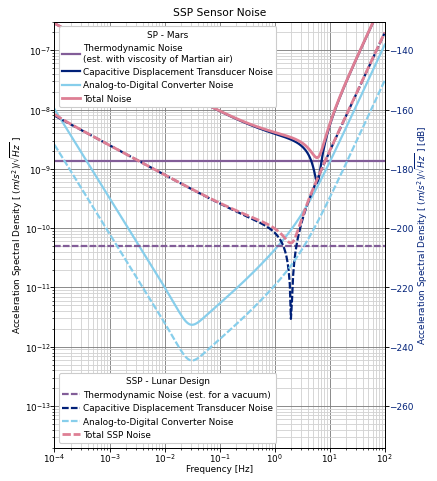

In [22]:
# Produce the SSP_Sensor_Noise.pdf figure which plots each of the noise components, 
# and the improvements between Mars and the Moon
plot_seismometer_improvements()


# Section 4 - Performance on Mars - SP_Mars.pdf

flickerCorner= 1


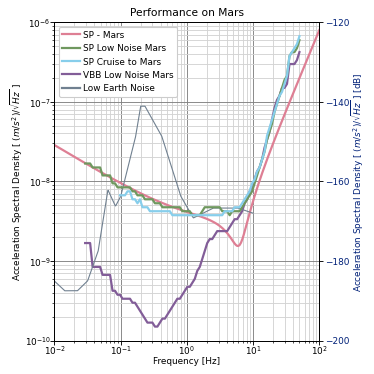

finished this figure


In [23]:
# SP_Mars.pdf
# shows performance on Mars, and quiet periods during cruise and after deployment (for both VBB and SP)

seismograms = [
  ]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=True,sp_mars_color=MUTED_PINK,
                            show_sp_lunar_target=False,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=True,Mars_noise_SP_color=MUTED_MID_GREEN,
                            show_Mars_noise_VBB=True,Mars_noise_VBB_color=MUTED_PURPLE,
                            show_Mars_cruise=True,Mars_cruise_color=MUTED_LIGHT_BLUE,
                            show_low_moon_noise=False,low_moon_noise_color='slategray',
                            xlim=(0.01,100), ylim=(1e-10,1e-6),                        
                            title='Performance on Mars',
#                             12 cm wide figure
                            figname='plots/SP_Mars.pdf',figsize=(4.72,4.72))


print('finished this figure')

# Section 5 -  Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - SSP_Noise_Fig5.pdf


flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.274
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.274
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.108
/Us

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
30% -165.2
50% -163.2
70% -161.5
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise (SP) percentiles
(10th, 30th, 50th, 70th, 90th) 0.33
10% -166.7
30% -165.3
50% -163.3
70% -161.6
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.14
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.16
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.17
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.18
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.20
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.21
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.22
/Use

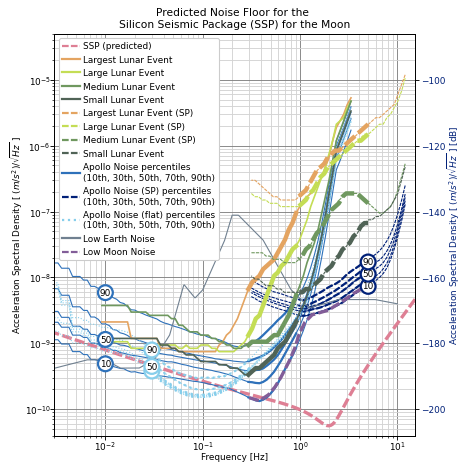

Calculated for 672 hours. The final version should be calculated for 672 hours


In [24]:
# Figure 5 of Standing on Apollo’s Shoulders: a Microseismometer for the Moon
# The events used (from large to small are: 1973-03-13T08:01, 1971-04-17T07:04, 1973-07-23T01:14, 1973-10-01T04:00. 1973-07-23T01:14 
# was classified by \cite{Nakamura_1981} as a meteoroid impact, and the remaining events were shallow moonquakes.

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],  
  ]

sp_seismograms = [
    #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dashed'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dashed'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dashed'],
#     'Small Lunar Event'
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'dashed'],   
]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]

noise_periods = [
# #     there are a lot of glitches on these traces, so using a different time
# #         [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a large sigmal at 1971-04-20T07:04:00.000000Z as well as many smaller signals 
#     (at 1971-05-01T08, 1971-04-30T03, 1971-04-29T06)
#     until 1971-05-12T20:09 , so it's working during this period. 

# #     so we know it is working ok then. S14 has very low noise (when there are no glitches)
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': 'Apollo Noise percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, None,'dotted',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2,[10,50,90],0.01],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': None,'linestyle': 'dashed', 'period_limits': (0.0833,3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 5, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': 'Apollo Noise (SP) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
    
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, None,'dotted',(0.0833,3),(-200, -50, 0.1),3600,ppsd_hours,0.33,[10,50,90],5],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
     
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 3, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.03, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dotted', 'period_limits': (3.3,33), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 3, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
#     do not keep
#         {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.08},
#     {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'S16 - flat\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None},

    
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, None,'dotted',(0.3,100),(-250, -50, 0.1),3600,ppsd_hours,10,[10,90],0.03],
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],
    
]



stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color=MUTED_PURPLE,
                            noise_periods=noise_periods, 
                            ylim=(4e-11,5e-5),xlim=(0.003,15),
                            title='Predicted Noise Floor for the \nSilicon Seismic Package (SSP) for the Moon',
#                                      15 cm wide figure 
                            figname='plots/SSP_Noise_Fig5.pdf',figsize=(5.91,5.91))


print('Calculated for {} hours. The final version should be calculated for 672 hours'.format(ppsd_hours))


In [25]:
# Noise Spectra - Percentiles for S12

# Apollo Noise, dominant period=2.2
# 10% -197.1
# 30% -191.3
# 50% -187.2
# 70% -183.3
# 90% -177.6

# Apollo Noise (SP), dominant period=0.33
# 10% -166.7
# 30% -165.2
# 50% -163.1
# 70% -161.4
# 90% -159.3

# Apollo Noise (flat), dominant_period=10
# 10% -196.4
# 30% -196.0
# 50% -195.4
# 70% -192.7
# 90% -186.9

# Section 6 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Whitepaper version

Produced for 'MoonShake: a future Lunar Seismic Network Delivered by Penetrators' - a whitepaper for the 2023 Decadal Survey


flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.44
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.49
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.145
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.149
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/

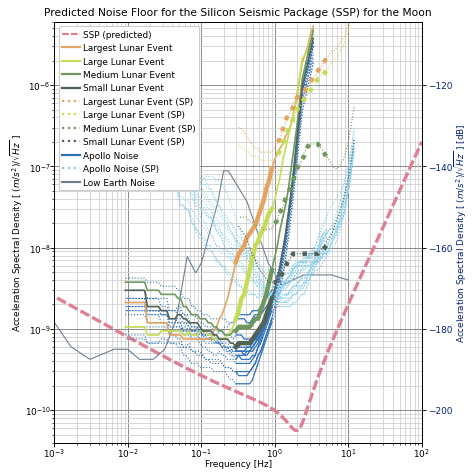

In [26]:
# SSP_Noise_Fig1.pdf for for whitepaper
# 'MoonShake: a future Lunar Seismic Network Delivered by Penetrators' - a whitepaper for the 2023 Decadal Survey

# This figure uses several examples of noise at different times. The newer version of the figure (SSP_Noise_Fig1.pdf)
# uses perecentiles from the noise over a 28 day period. 

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],
  ]

sp_seismograms = [
    #     #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event (SP)', 'dotted'],
  ]

sp_noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'SHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'SHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'SHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'SHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'SHZ']
]

noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'MHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'MHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'MHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'MHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'MHZ']
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=False,low_moon_noise_color='slategray',
                            ylim=(4e-11,6e-6),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon',
                            figname='plots/SSP_Noise_Fig1.pdf')

# Section 7 - Target Sensitivity for the Lunar Geophysical Network 

flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.274
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.274
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.108
/Us

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
30% -165.2
50% -163.2
70% -161.5
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise (SHZ) percentiles
(10th, 30th, 50th, 70th, 90th) 0.33
10% -166.7
30% -165.3
50% -163.3
70% -161.6
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.14
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.16
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.17
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.18
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.20
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.21
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.22
/Us

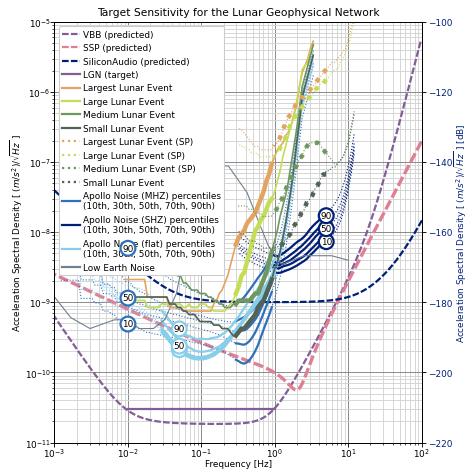

In [27]:
# Lunar Geophysical Network - LGN_Noise_VBB_v2.pdf - new version which includes percentiles 
# for the noise

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],  
  ]

sp_seismograms = [
    #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'dotted'],   
]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]

noise_periods = [
# #     there are a lot of glitches on these traces, so using a different time
# #         [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T07:04:00.000000Z, 
# #     so we know it is working ok then. S14 has very low noise (when there are no glitches)
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': 'Apollo Noise (MHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, None,'dotted',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.0833,3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 5, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': 'Apollo Noise (SHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},

    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, None,'dotted',(0.0833,3),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP)','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
  
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.05, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,33), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},

    
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, None,'dotted',(0.3,100),(-250, -50, 0.1),3600,ppsd_hours,10],
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (flat)','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],
    
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            show_vbb_target=True,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=True,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=True,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            noise_periods=noise_periods, 
                            figname='plots/LGN_Noise_VBB_v2.pdf')
    

flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.44
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.49
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.145
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.149
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.164
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16

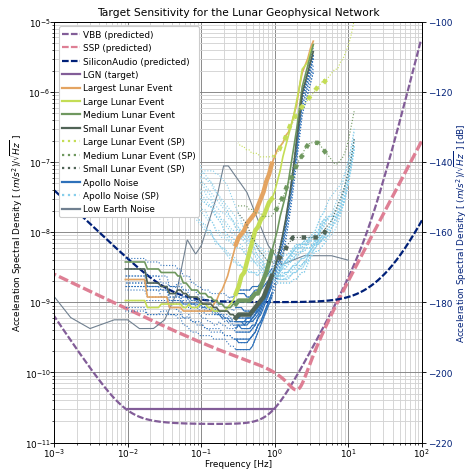

In [28]:
# Lunar Geophysical Network - LGN_Noise_VBB_old.pdf - version using example noise 

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],
  ]

sp_seismograms = [
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event (SP)', 'dotted'],
  ]

sp_noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'SHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'SHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'SHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'SHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'SHZ']
]

noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'MHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'MHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'MHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'MHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'MHZ']
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            show_vbb_target=True,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=True,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=True,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            figname='plots/LGN_Noise_VBB_original.pdf')
    

# Section 8 - SSP Sensor noise compared with spectra from the Moon and Mars - AGU 2019 elightning talk version

flickerCorner= 1
flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56


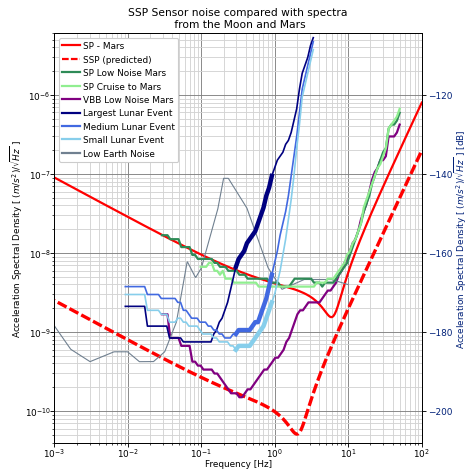

In [29]:
# SSP for AGU 2019 

# Note that we didn't include the ADC noise in the total plot for AGU 2019 elightning talk - SSP_Noise_AGU.pdf
# we decided to change this for the paper (the final paper also has a lower value for the 
# voltage noise on the ADC - VNoiseADC)  

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', 'navy', 'Largest Lunar Event', 'solid'],
#     [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', 'royalblue', 'Medium Lunar Event', 'solid'],
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'MHZ', 'skyblue', 'Small Lunar Event', 'solid'],
  ]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=True,sp_mars_color='red',
                            show_sp_lunar_target=True,sp_lunar_target_color='red',
#                             show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
#                             show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=True,Mars_noise_SP_color='seagreen',
                            show_Mars_noise_VBB=True,Mars_noise_VBB_color='purple',
                            show_Mars_cruise=True,Mars_cruise_color='lightgreen',
#                             show_low_moon_noise=False,low_moon_noise_color='slategray',
                            ylim=(4e-11,6e-6),
                            # note that withADC was false, which is different from the normal way we      
                            # are calculating this   
                            withADC=False, 
                            title='SSP Sensor noise compared with spectra\n from the Moon and Mars',
                            figname='plots/SSP_Noise_AGU.pdf')

# Section 9 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Comparing 3 components (MHZ, MH1, MH2)

This figure compares the signals on the three different components (MHZ, MH1, MH2). Not used in the paper.

## Section 9a - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Comparing vertical and horizontal noise (MHZ, MH1)

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.351
Initial no. of samples: 572401, Final no. of samples: 545736
Count of psd segments  44
S12 - MHZ 2.2
10% -186.8
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MH1/S12.XA..MH1.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MH1/S12.XA..MH1.1972.351
Initial no. of samples: 572401, Final no. of samples: 521769
Count of psd segments  42
S12 - MH1 2.2
10% -175.6
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
Initial no. of samples: 572401, Final no. of samples: 570284
Count of psd segments  46
S14 - MHZ 2.2
10% -190.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHN/S14.XA..MHN.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MH

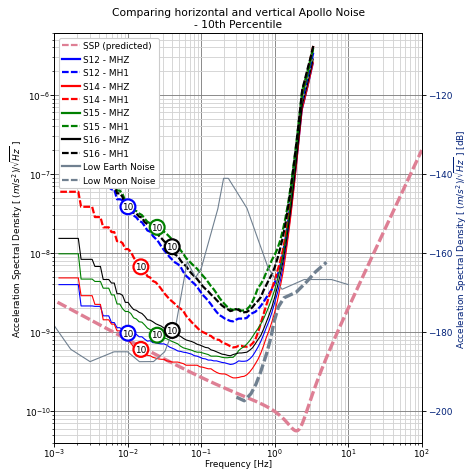

In [30]:
##### Noise recorded at each of the Apollo seismic stations
##### Comparing vertical and horizontal noise
ppsd_hours_24=24 # 24 hours for this plot
seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]


noise_periods = [
# MHZ/MHN
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'S12 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.01, 'linewidth' : 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MH1', 'color': 'blue','label': 'S12 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.01, 'linewidth' : 2},
    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'S14 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.015, 'linewidth' : 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHN', 'color': 'red','label': 'S14 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.015, 'linewidth' : 2},
  
#     Note that this section has some very low noise periods, but the seismometer isn't working at all
#     {'starttime': UTCDateTime('1972-12-15T06:39:29'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.025},
  
    
        # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'S15 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.025, 'linewidth' : 1},
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHN', 'color': 'green','label': 'S15 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.025, 'linewidth' : 2},

    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'S16 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.04, 'linewidth' : 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MH1', 'color': 'black','label': 'S16 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.04, 'linewidth' : 2},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 


]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            noise_periods=noise_periods, 
                            ylim=(4e-11,6e-6),
                            title='Comparing horizontal and vertical Apollo Noise\n- 10th Percentile',
                            figname='plots/Apollo_noise_MHZ_MH1_10.pdf')


flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
Initial no. of samples: 47701, Final no. of samples: 47694
Count of psd segments  2
S12 - MHZ 2.2
90% -182.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MH1/S12.XA..MH1.1972.350
Initial no. of samples: 47701, Final no. of samples: 47207
Count of psd segments  2
S12 - MH1 2.2
90% -165.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
Initial no. of samples: 47701, Final no. of samples: 47580
Count of psd segments  2
S14 - MHZ 2.2
90% -191.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHN/S14.XA..MHN.1971.105
Initial no. of samples: 47701, Final no. of samples: 47535
Count of psd segments  2
S14 - MH1 2.2
90% -184.8
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
Initial no. of samples: 47701, Final no. of samples: 47684
Count of psd segments  2
S15 - MHZ 2.2
90% -164.2
/Us

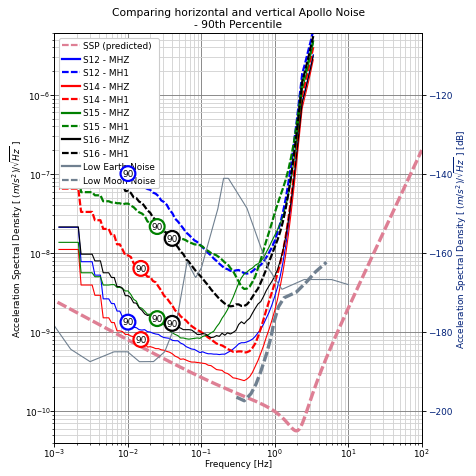

In [31]:
##### Noise recorded at each of the Apollo seismic stations
##### Comparing vertical and horizontal noise
ppsd_hours_24=2 # 24 hours for this plot
seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]


noise_periods = [
# MHZ/MHN
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'S12 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MH1', 'color': 'blue','label': 'S12 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.01, 'linewidth': 2},
    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'S14 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.015, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHN', 'color': 'red','label': 'S14 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.015, 'linewidth': 2},
  
#     Note that this section has some very low noise periods, but the seismometer isn't working at all
#     {'starttime': UTCDateTime('1972-12-15T06:39:29'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.025},
  
    
        # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'S15 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.025, 'linewidth': 1},
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHN', 'color': 'green','label': 'S15 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.025, 'linewidth': 2},

    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'S16 - MHZ','linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.04, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MH1', 'color': 'black','label': 'S16 - MH1','linestyle': 'dashed', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours_24, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.04, 'linewidth': 2},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 


]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            noise_periods=noise_periods, 
                            ylim=(4e-11,6e-6),
                            title='Comparing horizontal and vertical Apollo Noise\n- 90th Percentile',
                            figname='plots/Apollo_noise_MHZ_MH1_90.pdf')


## Section 9b - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Comparing vertical and horizontal events (MHZ, MH1)

/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.36
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.36
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.36
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH1/S12.XA..MH1.1973.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MH2/S12.XA..MH2.1973.3


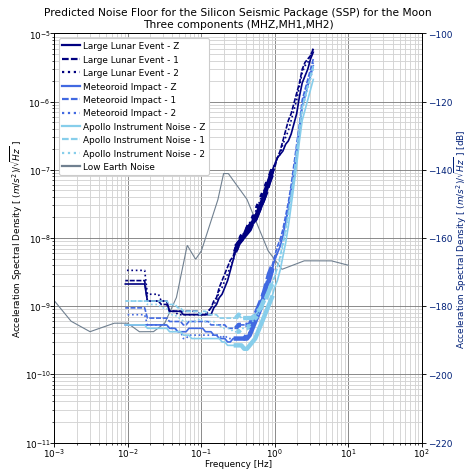

In [32]:
# This figure compares the signals on the three different components (MHZ, MH1, MH2) 
# Not used in the paper. 

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', 'navy', 'Large Lunar Event - Z', 'solid'],
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MH1', 'navy', 'Large Lunar Event - 1','dashed'],
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MH2', 'navy', 'Large Lunar Event - 2','dotted'],  
    
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MHZ', 'royalblue', 'Meteoroid Impact - Z','solid'],
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MH1', 'royalblue', 'Meteoroid Impact - 1','dashed'],   
  [UTCDateTime('1973-02-05T20:59:00.000000Z'), 'S12', 'MH2', 'royalblue', 'Meteoroid Impact - 2','dotted'],
    
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MHZ', 'skyblue', 'Apollo Instrument Noise - Z','solid'],
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MH1', 'skyblue', 'Apollo Instrument Noise - 1','dashed'],
  [UTCDateTime('1973-01-03T22:48:00.000000Z'), 'S12', 'MH2', 'skyblue', 'Apollo Instrument Noise - 2','dotted']
  ]

# spectra in root Hertz????
plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,
                        title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon\nThree components (MHZ,MH1,MH2)',
                        figname='plots/Apollo_noise_3components.pdf')

# Section 10 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared with noise at each Apollo station

 

## Section 10a - 10th percentile 

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.361
/

Initial no. of samples: 16027201, Final no. of samples: 15950111
Count of psd segments  1336
Apollo Noise S14 2.2
10% -197.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.74
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.75
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.76
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.77
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.78
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.79
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.80
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.81
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.82
/Users/cnunn/lunar_data/GEOS

Initial no. of samples: 16027201, Final no. of samples: 15063377
Count of psd segments  1262
Apollo Noise S16 2.2
10% -194.4
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/luna

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.116
/Users/cnunn/lu

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise S14 (SP) 0.33
10% -166.7
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.213
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.214
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.215
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.216
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.217
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.218
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.219
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.220
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.221
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.222
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.223
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.22

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
None 0.33
10% -165.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.361
/Users/cnunn/lun

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
Apollo Noise S16 (SP) 0.33
10% -165.1


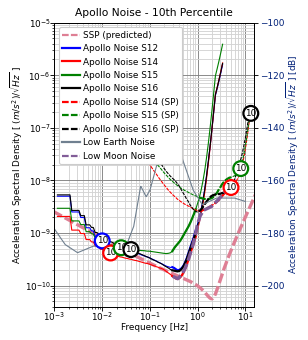

In [33]:
##### Noise recorded at each of the Apollo seismic stations

seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]


noise_periods = [
# MHZ
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.01, 'linewidth' : 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'Apollo Noise S12','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 
  
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.015, 'linewidth' : 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'Apollo Noise S14','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 

#     Note that this section has some very low noise periods, but the seismometer isn't working at all
#     {'starttime': UTCDateTime('1972-12-15T06:39:29'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.025},
  
    
        # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.025, 'linewidth' : 1},
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'Apollo Noise S15','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 

    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 0.04, 'linewidth' : 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'Apollo Noise S16','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 

    

    

    
# SHZ

    
#     short-period instrument didn't work on S12 
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'SHZ', 'blue', 'S12 - MHZ'],


#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', 'S14 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
  
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 5, 'linewidth' : 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': 'Apollo Noise S14 (SP)', 'linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 
  


#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', 'S15 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],   
   
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 8, 'linewidth' : 1},
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': 'Apollo Noise S15 (SP)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 
  
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', 'S16 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : [10], 'label_pos': 13, 'linewidth' : 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': 'Apollo Noise S16 (SP)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10], 'percentile_labels' : None, 'label_pos': None, 'linewidth' : 2}, 
  

]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color=MUTED_PURPLE,
                            noise_periods=noise_periods, 
                            xlim=(0.001,15),
                            ylim=(4e-11,1e-5),figsize=(10*.39,10*.39*1.1),
                            title='Apollo Noise - 10th Percentile',
                            figname='plots/Apollo_noise_10.pdf')


## Section 10b - 90th percentile 

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.361
/

Initial no. of samples: 16027201, Final no. of samples: 15950111
Count of psd segments  1336
Apollo Noise S14 2.2
90% -177.5
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.74
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.75
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.76
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.77
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.78
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.79
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.80
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.81
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.82
/Users/cnunn/lunar_data/GEOS

Initial no. of samples: 16027201, Final no. of samples: 15063377
Count of psd segments  1262
Apollo Noise S16 2.2
90% -176.5
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/luna

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.116
/Users/cnunn/lu

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise S14 (SP) 0.33
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.213
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.214
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.215
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.216
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.217
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.218
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.219
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.220
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.221
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.222
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.223
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.22

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
None 0.33
90% -158.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.361
/Users/cnunn/lun

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-09T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
Apollo Noise S16 (SP) 0.33
90% -158.1


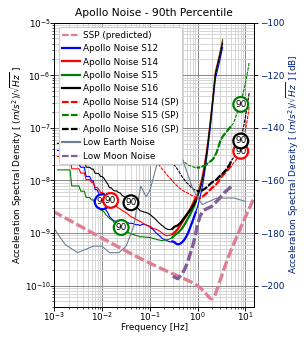

In [34]:
# Noise recorded at each of the Apollo seismic stations

seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]

# 0.01, 0.015, 0.0025, 0.04

noise_periods = [
# MHZ
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'Apollo Noise S12','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.015, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'Apollo Noise S14','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
   
    # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.025, 'linewidth': 1},
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'Apollo Noise S15','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},

    
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': None,'linestyle': 'solid', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 0.04, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'Apollo Noise S16','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 

    

    

    
# SHZ

    
#     short-period instrument didn't work on S12 
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'SHZ', 'blue', 'S12 - MHZ'],


#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', 'S14 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
  
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 8, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': 'Apollo Noise S14 (SP)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  


#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', 'S15 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],   
   
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 8, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': 'Apollo Noise S15 (SP)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', 'S16 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': None,'linestyle': 'dashed', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : [90], 'label_pos': 8, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': 'Apollo Noise S16 (SP)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  

]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color=MUTED_PURPLE,
                            noise_periods=noise_periods, 
                            xlim=(0.001,15),
                            ylim=(4e-11,1e-5),figsize=(10*.39,10*.39*1.1),
                            title='Apollo Noise - 90th Percentile',
                            figname='plots/Apollo_noise_90.pdf')


## Section 10c - 10, 50 and 90th percentile 

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.361
/

Initial no. of samples: 16027201, Final no. of samples: 15950111
Count of psd segments  1336
Apollo Noise S14 (MHZ) percentiles
 (10th, 30th, 50th, 70th, 90th) 2.2
10% -197.1
50% -187.6
90% -177.5
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.73
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.74
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.75
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.76
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.77
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.78
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.79
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.80
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S15/MHZ/S15.XA..MHZ.1973.81
/Users/cnunn/lunar_data/GEOSCOPE_

Initial no. of samples: 16027201, Final no. of samples: 15063377
Count of psd segments  1262
Apollo Noise S16 (MHZ) percentiles
 (10th, 30th, 50th, 70th, 90th) 2.2
10% -194.4
50% -185.8
90% -176.5
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
50% -163.2
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.19

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise S14 (SHZ) percentiles
 (10th, 30th, 50th, 70th, 90th) 0.33
10% -166.7
50% -163.3
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.213
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.214
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.215
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.216
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.217
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.218
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.219
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.220
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.221
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.222
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.223
/Users/cn

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
None 0.33
10% -165.1
50% -162.2
90% -158.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/SHZ/S16.XA..SHZ.197

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
Apollo Noise S16 (SHZ) percentiles
 (10th, 30th, 50th, 70th, 90th) 0.33
10% -165.1
50% -162.3
90% -158.1


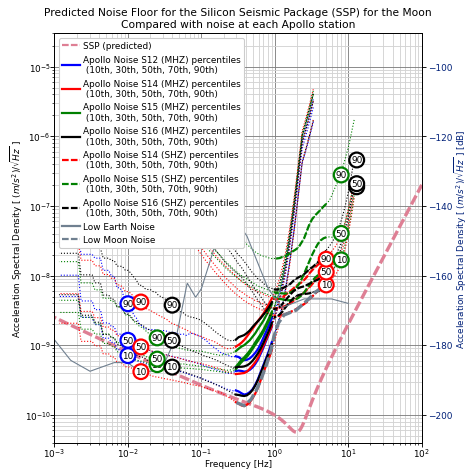

In [35]:
##### Noise recorded at each of the Apollo seismic stations

seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]
# 0.01, 0.015, 0.0025, 0.04

noise_periods = [
# MHZ
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'Apollo Noise S12 (MHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2}, 
  
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.015, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'Apollo Noise S14 (MHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
   

        # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.025, 'linewidth': 1},
    {'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'Apollo Noise S15 (MHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},

    
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.04, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'Apollo Noise S16 (MHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 

    

    

    
# SHZ

    
#     short-period instrument didn't work on S12 
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'SHZ', 'blue', 'S12 - MHZ'],


#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', 'S14 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
  
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': None,'linestyle': 'dotted', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 5, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'red','label': 'Apollo Noise S14 (SHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  


#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', 'S15 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],   
   
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 8, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'green','label': 'Apollo Noise S15 (SHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', 'S16 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': None,'linestyle': 'dotted', 'period_limits': (0.0833,20), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : [10,50,90], 'label_pos': 13, 'linewidth': 1},
    {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'black','label': 'Apollo Noise S16 (SHZ) percentiles\n (10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,50,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  

]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            noise_periods=noise_periods, 
                            ylim=(4e-11,3e-5),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon\nCompared with noise at each Apollo station',
                            figname='plots/Apollo_noise_percentiles.pdf')


## Section 10d - fill between 10th and 90th percentile 

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.350
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.351
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.352
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.353
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.354
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.355
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.356
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.357
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.358
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.359
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.360
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S12/MHZ/S12.XA..MHZ.1972.361
/

/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.364
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.365
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1972/S16/MHZ/S16.XA..MHZ.1972.366
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.4
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.5
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.6
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.7
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.8
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.9
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.10
/User

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise S14 (SHZ)
 (10th-90th percentile) 0.33
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.213
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.214
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.215
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.216
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.217
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.218
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.219
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.220
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.221
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.222
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.XA..SHZ.1971.223
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S15/SHZ/S15.X

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-15T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-18T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-21T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-24T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-25T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-28T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T12:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T14:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1972-12-31T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T16:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T18:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T20:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-03T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-06T22:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T00:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T02:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-07T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T04:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T06:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T08:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1973-01-10T10:15:40.008807Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  965
Apollo Noise S16 (SHZ)
 (10th-90th percentile) 0.33


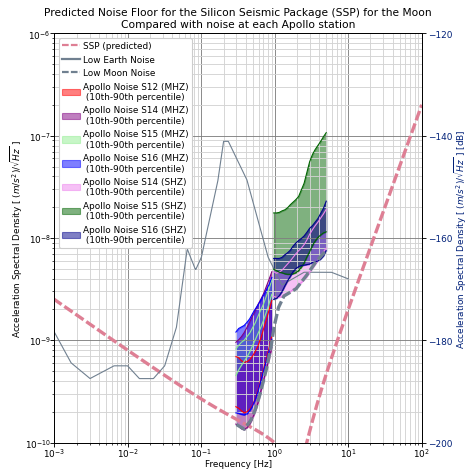

In [36]:
##### Noise recorded at each of the Apollo seismic stations

seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]

noise_periods = [
# MHZ
 {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'red','label': 'Apollo Noise S12 (MHZ)\n (10th-90th percentile)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1}, 
  
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ','red', 'S14 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
    
{'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'purple','label': 'Apollo Noise S14 (MHZ)\n (10th-90th percentile)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

#     Note that this section has some very low noise periods, but the seismometer isn't working at all
#     {'starttime': UTCDateTime('1972-12-15T06:39:29'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.025},
  
    
        # this is a nice clear shallow event, and we know the seismometer is working well 
#     5 smi:nakamura81/event/06051
{'starttime': UTCDateTime('1973-03-13T08:01:00.000000Z'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'lightgreen','label': 'Apollo Noise S15 (MHZ)\n (10th-90th percentile)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', None,'dotted',(0.3,1000),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'MHZ', 'black', 'S16 - MHZ','dotted',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
  {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'blue','label': 'Apollo Noise S16 (MHZ)\n (10th-90th percentile)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},
  
    
    #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'MHZ', 'blue', 'S12 - MHZ','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],
# #     there are a lot of glitches on these traces, so using a different time
# #     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T09:04:00.000000Z, 
# #       so we know it is working ok then. 

    

    

    
# SHZ

    
#     short-period instrument didn't work on S12 
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S12', 'SHZ', 'blue', 'S12 - MHZ'],


#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ','red', 'S14 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
  
  {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': 'violet','label': 'Apollo Noise S14 (SHZ)\n (10th-90th percentile)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},
  


#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S15', 'SHZ', 'green', 'S15 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],   
   
  {'starttime': UTCDateTime('1971-08-01T00:00:00.000000Z'), 'station_code': 'S15', 'channel': 'SHZ', 'color': 'darkgreen','label': 'Apollo Noise S15 (SHZ)\n (10th-90th percentile)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},
  
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', None,'dotted',(0.0833,20),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S16', 'SHZ', 'black', 'S16 - SHZ','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],

  {'starttime': UTCDateTime('1972-12-15T02:45:40.000000Z'), 'station_code': 'S16', 'channel': 'SHZ', 'color': 'darkblue','label': 'Apollo Noise S16 (SHZ)\n (10th-90th percentile)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},
  

]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            noise_periods=noise_periods, 
                            ylim=(1e-10,1e-6),fill_between=True,
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon\nCompared with noise at each Apollo station',
                            figname='plots/Apollo_noise.pdf')


# Section 11 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared with noise at each Apollo station (flat response)

flickerCorner= 1
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.14
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.16
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.17
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.18
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.20
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.21
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.22
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.23
/Users/cnunn/

Initial no. of samples: 11581925, Final no. of samples: 11290284
Count of psd segments  945
S14 - flat
(10th, 30th, 50th, 70th, 90th) 10
10% -234.9
30% -221.5
50% -213.5
70% -208.2
90% -203.6
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.180
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.181
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.182
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.183
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.184
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.185
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.186
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.187
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.188
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S15/MHZ/S15.XA..MHZ.1975.189
/Users/cnunn/lunar_data/GEOS

Initial no. of samples: 16027199, Final no. of samples: 13852681
Count of psd segments  1160
S16 - flat
(10th, 30th, 50th, 70th, 90th) 10
10% -188.8
30% -186.4
50% -185.39999999999998
70% -184.3
90% -178.2


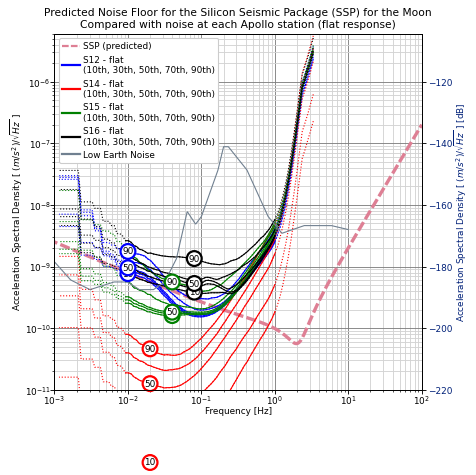

In [37]:
# Noise recorded at each of the Apollo seismic stations

# Noise recorded at each of the Apollo seismic stations

seismograms = [
]

sp_seismograms = [
  ]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]



noise_periods = [
  

    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': 'blue','label': 'S12 - flat\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ','blue', None,'dotted',(0.3,2000),(-250, -50, 0.1),3600,ppsd_hours,10],
#  [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ','blue', 'S12 - flat','solid',(1,100),(-250, -50, 0.1),3600,ppsd_hours,10],
    
  
    {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.02, 'linewidth': 1},
    {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S14', 'channel': 'MHZ', 'color': 'red','label': 'S14 - flat\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

    
#     [UTCDateTime('1976-09-19T00:00:00.000'), 'S14', 'MHZ','red', None,'dotted',(0.3,2000),(-250, -50, 0.1),3600,ppsd_hours,10],
#     [UTCDateTime('1976-09-19T00:00:00.000'), 'S14', 'MHZ','red', 'S14 - flat','solid',(1,100),(-250, -50, 0.1),3600,ppsd_hours,10],
   
    {'starttime': UTCDateTime('1975-06-29T00:00:00.000'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.04, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-06-29T00:00:00.000'), 'station_code': 'S15', 'channel': 'MHZ', 'color': 'green','label': 'S15 - flat\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

    
#     [UTCDateTime('1975-06-29T00:00:00.000'), 'S15', 'MHZ','green', None,'dotted',(0.3,2000),(-250, -50, 0.1),3600,ppsd_hours,10],
#     [UTCDateTime('1975-06-29T00:00:00.000'), 'S15', 'MHZ','green', 'S15 - flat','solid',(1,100),(-250, -50, 0.1),3600,ppsd_hours,10],
 
    {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': None,'linestyle': 'dotted', 'period_limits': (0.3,2000), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.08, 'linewidth': 1},
    {'starttime': UTCDateTime('1976-09-19T00:00:00.000'), 'station_code': 'S16', 'channel': 'MHZ', 'color': 'black','label': 'S16 - flat\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 10, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 1},

    
#     [UTCDateTime('1976-09-19T00:00:00.000'), 'S16', 'MHZ','black', None,'dotted',(0.3,2000),(-250, -50, 0.1),3600,ppsd_hours,10],
#     [UTCDateTime('1976-09-19T00:00:00.000'), 'S16', 'MHZ','black', 'S16 - flat','solid',(1,100),(-250, -50, 0.1),3600,ppsd_hours,10],
   

# ]



#     {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.0833,3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 5},
#     {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': 'Apollo Noise (SHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None},
  
#      {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.03},
#     {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None},
    ]
    

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
                                 flat_seismograms = flat_seismograms, 
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=False,low_moon_noise_color='slategray',
                            noise_periods=noise_periods, 
                            ylim=(1e-11,6e-6),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon\nCompared with noise at each Apollo station (flat response)',
                            figname='plots/Apollo_noise_flat.pdf')


We are not sure why the flat noise shows such a range over the different stations. Possible reasons include:

1) Different gains which are not specified in the log files.

2) Contamination with noise (possibly local noise such as thermal pops from the lander and instruments) 

3) Incorrect specification of the feedback filter provided as part of the seismometer package. The feedback filter was an active filter, and therefore incorrect specfication could have very unusual results. 

4) Contamination with some periods not operating in flat mode. 

Further investigation is required to determine which (if any) of these scenarios is correct. We choose the S12 noise for the main plot because the amplitiudes seem at frequencies above 0.3 Hz (where it can be compared to the mid-period instrument in peaked mode. 



# Section 12 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Specific noise examples (including flat noise) 

flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1976/S12/MHZ/S12.XA..MHZ.1976.66
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.44
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.44
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MH

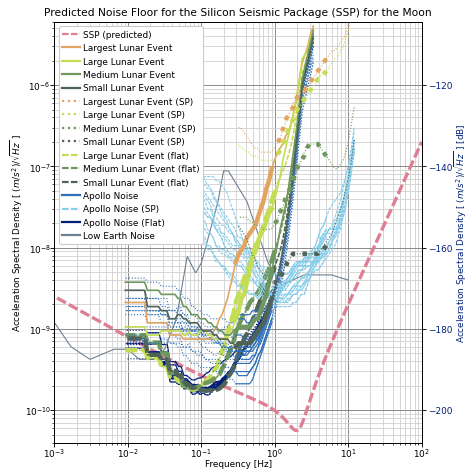

In [38]:
# SSP_Noise_Fig5_with_examples.pdf
# Plots selection SSP predicted, a selection of events and a selection of noise events  

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],
  ]

sp_seismograms = [
    #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event (SP)', 'dotted'],
  ]

flat_seismograms = [
  [UTCDateTime('1976-03-06T10:16:00.000000Z'), 'S12', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event (flat)', 'dashed'],
  [UTCDateTime('1975-02-13T22:05:00.000000Z'), 'S12', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event (flat)', 'dashed'],
#     adjusting the catalog pick which is a bit late
  [UTCDateTime('1975-01-12T03:17:00.000000Z')+240., 'S12', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event (flat)', 'dashed'],
]


sp_noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'SHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'SHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'SHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'SHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'SHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'SHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'SHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'SHZ']
]

noise_seismograms = [
    ['1973-02-13T04:52:40.000000Z', 'S16', 'MHZ'], 
    ['1973-02-18T04:34:40.000000Z', 'S16', 'MHZ'], 
    ['1973-05-25T16:42:40.000000Z', 'S16', 'MHZ'],  
    ['1973-05-29T01:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-13T22:24:40.000000Z', 'S16', 'MHZ'], 
    ['1973-06-24T22:30:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-16T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-23T00:50:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-28T11:16:40.000000Z', 'S16', 'MHZ'], 
    ['1973-07-31T09:31:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-03T18:37:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-06T06:39:40.000000Z', 'S16', 'MHZ'], 
    ['1973-08-25T02:21:40.000000Z', 'S16', 'MHZ'], 
    ['1973-10-22T07:41:40.000000Z', 'S16', 'MHZ']
]

flat_noise_seismograms = [
    ['1975-01-12T02:17:00.000000Z',  'S12', 'MHZ'], 
    ['1975-01-12T23:28:00.000000Z',  'S12', 'MHZ'], 
    ['1975-02-13T21:05:00.000000Z',  'S12', 'MHZ'], 
    ['1975-11-10T06:56:00.000000Z',  'S12', 'MHZ'], 
    ['1976-03-06T09:16:00.000000Z',  'S12', 'MHZ'], 
#     this is the noisiest so far 
    ['1976-05-16T11:36:00.000000Z',  'S12', 'MHZ'],   
 
#     midnight ones
    ['1974-10-17T19:50:30.000000Z', 'S12', 'MHZ'], 
     ['1974-11-16T09:25:00.000000Z', 'S12', 'MHZ'], 
    ['1974-12-15T23:42:00.000000Z', 'S12', 'MHZ'], 
    ['1975-01-14T14:19:00.000000Z', 'S12', 'MHZ'], 
    ['1975-03-14T18:33:00.000000Z', 'S12', 'MHZ'], 
    ['1975-07-10T17:41:00.000000Z', 'S12', 'MHZ'], 
#     ['1975-08-09T04:43:00.000000Z', 'S12', 'MHZ'], 
#     ['1975-09-07T16:15:00.000000Z', 'S12', 'MHZ'], 
#     ['1975-10-07T04:34:30.000000Z', 'S12', 'MHZ'], 
#     ['1975-11-05T17:49:00.000000Z', 'S12', 'MHZ'], 
#     ['1975-12-05T07:51:00.000000Z', 'S12', 'MHZ'], 
#     ['1976-01-03T22:25:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-02-02T13:00:00.000000Z', 'S12', 'MHZ'], 
#     ['1976-03-03T03:04:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-04-01T16:21:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-05-01T04:38:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-05-30T16:08:00.000000Z', 'S12', 'MHZ'], 
#     ['1976-06-29T03:07:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-08-27T01:26:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-09-25T13:28:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-10-25T02:20:30.000000Z', 'S12', 'MHZ'],
#     ['1976-11-23T16:07:30.000000Z', 'S12', 'MHZ'], 
#     ['1976-12-23T06:34:30.000000Z', 'S12', 'MHZ'], 
#     ['1977-01-21T21:11:30.000000Z', 'S12', 'MHZ']
]

stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat, seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                                 flat_seismograms=flat_seismograms, flat_noise_seismograms=flat_noise_seismograms,
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=False,low_moon_noise_color='slategray',
                            show_bit_noise=False,bit_noise_color='red',
                            ylim=(4e-11,6e-6),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon',
                            figname='plots/SSP_Noise_Fig5_with_examples.pdf')



# Section 13 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Noise before and after a signal 

Viewing Signals and Noise (before and after the signal)

/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.56


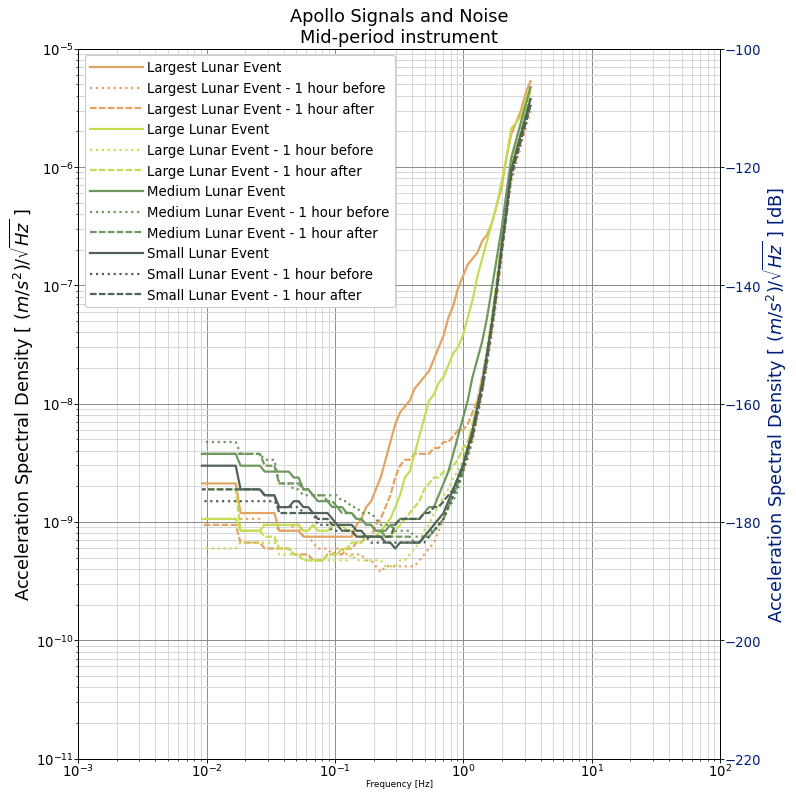

In [39]:
# Plot before and after noise curves, along with their signal - Mid-period

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],
  ]

sp_seismograms = [
  ]

stream = plot_before_and_after(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
                            title='Apollo Signals and Noise\nMid-period instrument',
                            figname='plots/MP_signal_and_noise.pdf')

/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.56


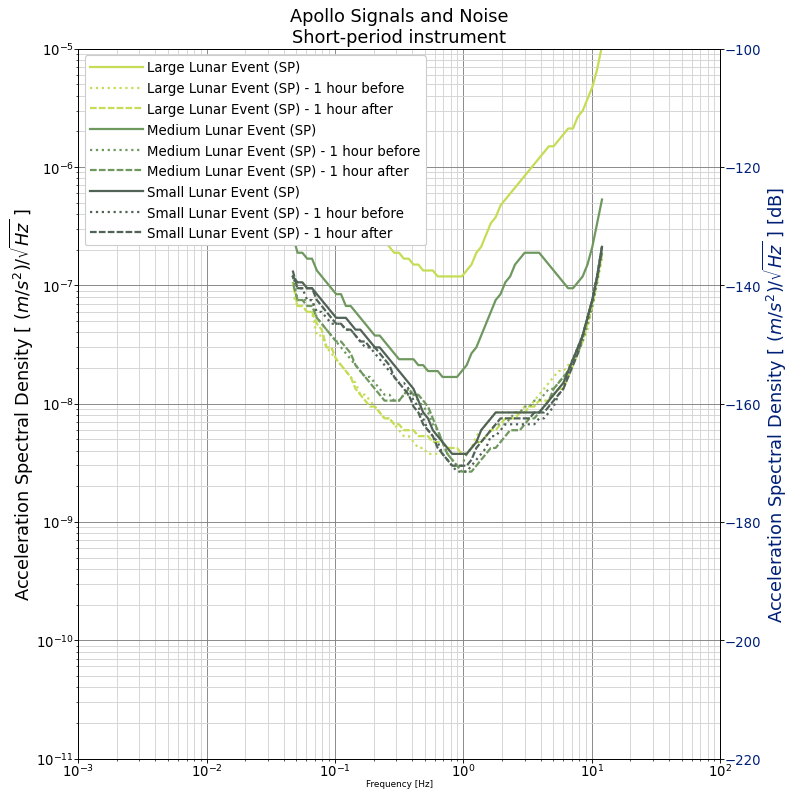

In [40]:
# Plot before and after noise curves, along with their signal - short-period

seismograms = [
  ]

sp_seismograms = [
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
    [UTCDateTime('1973-02-25T20:10:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event (SP)', 'dotted'],
  ]

stream = plot_before_and_after(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,seismograms=seismograms,sp_seismograms=sp_seismograms,
                            title='Apollo Signals and Noise\nShort-period instrument',
                            figname='plots/SP_signal_and_noise.pdf')

# Section 14 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Compared to Lognonné 2020 and Lognonné 2015

In [41]:
# Estimate of Apollo noise from Lognonne 2020 
lognonne_Apollo_noise_2020 = [
(1.44e-2, 2.53e-6),
(2.07e-2, 6.18e-7),
(2.80e-2, 1.18e-7),
(4.10e-2, 2.51e-8),
(6.82e-2, 5.47e-9),
(1.29e-1, 2.21e-9),
(2.09e-1, 1.11e-9),
(4.41e-1, 4.89e-10),
(8.19e-1, 2.50e-10),
(1.20e+0, 2.26e-10),
(1.63e+0, 3.27e-10),
(2.37e+0, 4.35e-10),
(4.78e+0, 7.19e-10),
(6.85e+0, 1.21e-9),
(8.34e+0, 2.21e-9),
(1.19e+1, 1.40e-8),
(1.44e+1, 5.72e-8),
(1.73e+1, 2.77e-7)
]


lognonne_2015_SP = [
(1.199e-3, 1.000e-4),
(1.884e-3, 5.918e-5),
(2.255e-3, 3.184e-5),
(3.336e-3, 1.840e-5),
(4.646e-3, 1.198e-5),
(6.665e-3, 5.077e-6),
(9.272e-3, 1.656e-6),
(1.253e-2, 1.158e-6),
(1.744e-2, 4.792e-7),
(2.501e-2, 1.600e-7),
(4.430e-2, 6.165e-8),
(7.621e-2, 3.239e-8),
(9.989e-2, 1.742e-8),
(2.122e-1, 7.563e-9),
(3.235e-1, 4.371e-9),
(4.934e-1, 3.056e-9),
(8.755e-1, 2.649e-9),
(1.755e+0, 3.973e-9),
(2.448e+0, 5.959e-9),
(3.854e+0, 9.599e-9),
(6.065e+0, 1.218e-8),
(9.265e+0, 1.963e-8)
]

lognonne_2015_LP_Peaked = [
(1.052e-3, 6.533e-7),
(1.601e-3, 1.322e-7),
(1.971e-3, 2.159e-8),
(1.968e-3, 9.373e-9),
(2.508e-3, 1.510e-8),
(2.826e-3, 6.250e-9),
(3.184e-3, 2.713e-9),
(3.486e-3, 2.984e-9),
(4.052e-3, 2.189e-9),
(4.568e-3, 1.425e-9),
(5.813e-3, 9.731e-10),
(9.135e-3, 6.040e-10),
(2.790e-2, 4.224e-10),
(5.259e-2, 3.328e-10),
(8.785e-2, 3.025e-10),
(1.707e-1, 2.500e-10),
(2.938e-1, 2.167e-10),
(3.976e-1, 2.884e-10),
(4.762e-1, 1.834e-10),
(5.889e-1, 3.173e-10),
(8.096e-1, 6.186e-10),
(1.148e+0, 1.943e-9),
(1.465e+0, 6.875e-9),
(1.760e+0, 2.265e-8),
(2.181e+0, 9.698e-8),
(2.468e+0, 4.568e-7),
(3.061e+0, 3.724e-6),
(3.159e+0, 7.615e-6)
]

# From:
# Lognonné, P.; Johnson, C. L. Planetary Seismology. In Treatise on Geophysics; Schubert, G., Ed.; 
# Elsevier: Oxford, 2015; pp 65–120. https://doi.org/10.1016/B978-0-444-53802-4.00167-6.
# and
# Lognonné, P.; Banerdt, W. B.; Pike, W. T.; Giardini, D.; Christensen, U.; Garcia, R. F.; 
# Kawamura, T.; Kedar, S.; Knapmeyer-Endrun, B.; Margerin, L.; Nimmo, F.; Panning, M.; Tauzin, B.; 
# Scholz, J.-R.; Antonangeli, D.; Barkaoui, S.; Beucler, E.; Bissig, F.; Brinkman, N.; Calvet, M.; 
# Ceylan, S.; Charalambous, C.; Davis, P.; van Driel, M.; Drilleau, M.; Fayon, L.; Joshi, R.; Kenda, B.; 
# Khan, A.; Knapmeyer, M.; Lekic, V.; McClean, J.; Mimoun, D.; Murdoch, N.; Pan, L.; Perrin, C.; Pinot, B.; 
# Pou, L.; Menina, S.; Rodriguez, S.; Schmelzbach, C.; Schmerr, N.; Sollberger, D.; Spiga, A.; Stähler, S.; 
# Stott, A.; Stutzmann, E.; Tharimena, S.; Widmer-Schnidrig, R.; Andersson, F.; Ansan, V.; Beghein, C.; 
# Böse, M.; Bozdag, E.; Clinton, J.; Daubar, I.; Delage, P.; Fuji, N.; Golombek, M.; Grott, M.; Horleston, A.; 
# Hurst, K.; Irving, J.; Jacob, A.; Knollenberg, J.; Krasner, S.; Krause, C.; Lorenz, R.; Michaut, C.; 
# Myhill, R.; Nissen-Meyer, T.; ten Pierick, J.; Plesa, A.-C.; Quantin-Nataf, C.; Robertsson, J.; Rochas, L.; 
# Schimmel, M.; Smrekar, S.; Spohn, T.; Teanby, N.; Tromp, J.; Vallade, J.; Verdier, N.; Vrettos, C.; Weber, R.; 
# Banfield, D.; Barrett, E.; Bierwirth, M.; Calcutt, S.; Compaire, N.; Johnson, C. L.; Mance, D.; Euchner, F.; 
# Kerjean, L.; Mainsant, G.; Mocquet, A.; Rodriguez Manfredi, J. A.; Pont, G.; Laudet, P.; Nebut, T.; 
# de Raucourt, S.; Robert, O.; Russell, C. T.; Sylvestre-Baron, A.; Tillier, S.; Warren, T.; Wieczorek, M.; 
# Yana, C.; Zweifel, P. Constraints on the Shallow Elastic and Anelastic Structure of Mars from InSight 
# Seismic Data. Nat. Geosci. 2020, 13 (3), 213–220. https://doi.org/10.1038/s41561-020-0536-y.

flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.274
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.274
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.108
/Us

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
30% -165.2
50% -163.2
70% -161.5
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-24T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-07T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-10T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise (SHZ) percentiles
(10th, 30th, 50th, 70th, 90th) 0.33
10% -166.7
30% -165.3
50% -163.3
70% -161.6
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.14
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.16
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.17
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.18
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.20
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.21
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.22
/Us

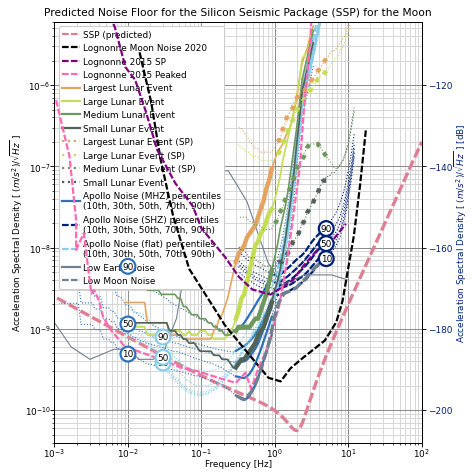

In [42]:
# This figure compares the noise estimated here to Lognonné 2020 and Lognonné 2015. 

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],  
  ]

sp_seismograms = [
    #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'dotted'],   
]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]

noise_periods = [
# #     there are a lot of glitches on these traces, so using a different time
# #         [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T07:04:00.000000Z, 
# #     so we know it is working ok then. S14 has very low noise (when there are no glitches)
    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, None,'dotted',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, None,'dotted',(0.0833,3),(-200, -50, 0.1),3600,ppsd_hours,0.33],
#     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP)','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
    
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, None,'dotted',(0.3,100),(-250, -50, 0.1),3600,ppsd_hours,10],
#     [UTCDateTime('1975-01-12T02:17:00.000000Z'), 'S12', 'MHZ',MUTED_LIGHT_BLUE, 'Apollo Noise (flat)','solid',(1,33),(-250, -50, 0.1),3600,ppsd_hours,10],
    
# ]

    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': 'Apollo Noise (MHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, None,'dotted',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2,[10,50,90],0.01],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.0833,3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 5, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': 'Apollo Noise (SHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
    
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, None,'dotted',(0.0833,3),(-200, -50, 0.1),3600,ppsd_hours,0.33,[10,50,90],5],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
     
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.03, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
    ]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            noise_periods=noise_periods, 
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            show_bit_noise=False,bit_noise_color='red',
                            show_lognonne=True, 
                            ylim=(4e-11,6e-6),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon',
                            figname='plots/SSP_Noise_Fig_compare_to_Lognonne.pdf')



# Section 15 - Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon - Show estimate for the bit noise 

We generate random fluctuations of 1 bit noise, and remove the instrument response. This shows the minimum noise that the instrument can realistically record. 
Note that this doesn't say anything about the frequency of the actual noise. 

flickerCorner= 1
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S12/MHZ/S12.XA..MHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/MHZ/S16.XA..MHZ.1973.274
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S14/SHZ/S14.XA..SHZ.1973.72
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.204
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1973/S16/SHZ/S16.XA..SHZ.1973.274
Using simple_deglitch() for the noise periods
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/MHZ/S14.XA..MHZ.1971.108
/Us

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
None 0.33
10% -166.7
30% -165.2
50% -163.2
70% -161.5
90% -159.2
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.105
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.106
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.107
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.108
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.109
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.110
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.111
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.112
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.113
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.114
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/S14/SHZ/S14.XA..SHZ.1971.115
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1971/

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-15T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-18T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-21T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-22T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-25T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-04-28T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T14:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T16:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-01T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T18:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T20:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-04T22:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-05T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T00:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T02:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T04:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-08T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T06:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T08:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T10:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarning: Already covered time spans detected (e.g. 1971-05-11T12:34:00.006900Z), skipping these slices.
  warnings.warn(msg)
/opt/anaconda3/envs/env36/lib/python3.6/site-packages/obspy/signal/spectral_estimation.py:882: UserWarni

Count of psd segments  1002
Apollo Noise (SHZ) percentiles
(10th, 30th, 50th, 70th, 90th) 0.33
10% -166.7
30% -165.3
50% -163.3
70% -161.6
90% -159.3
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.12
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.13
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.14
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.15
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.16
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.17
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.18
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.19
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.20
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.21
/Users/cnunn/lunar_data/GEOSCOPE_lunar_data/1975/S12/MHZ/S12.XA..MHZ.1975.22
/Us

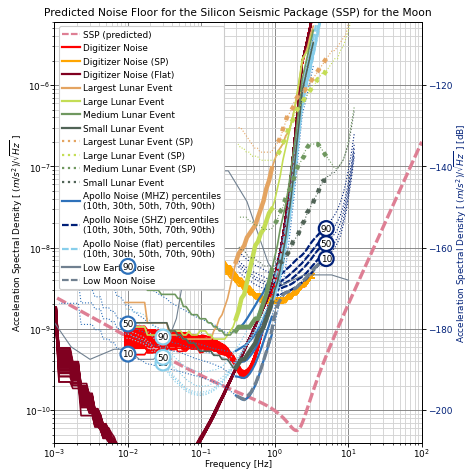

In [43]:
# This figure shows an approximation of the lowest bit noise (a random selection of up and down bits)

seismograms = [
  [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S12', 'MHZ', MUTED_ORANGE, 'Largest Lunar Event', 'solid'],
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'MHZ', MUTED_LIGHT_GREEN, 'Large Lunar Event', 'solid'],
#     meteoroid? 
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'MHZ', MUTED_MID_GREEN, 'Medium Lunar Event', 'solid'],
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'MHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'solid'],  
  ]

sp_seismograms = [
    #     'Largest Lunar Event'
    [UTCDateTime('1973-03-13T08:01:00.000000Z'), 'S14', 'SHZ',  MUTED_ORANGE, 'Largest Lunar Event (SP)', 'dotted'],
#     'Large Lunar Event'
    [UTCDateTime('1971-04-17T07:04:00.000000Z'), 'S14', 'SHZ',  MUTED_LIGHT_GREEN, 'Large Lunar Event (SP)', 'dotted'],
    #     meteoroid? , 'Medium Lunar Event'
    [UTCDateTime('1973-07-23T01:14:00.000000Z'), 'S16', 'SHZ', MUTED_MID_GREEN, 'Medium Lunar Event (SP)', 'dotted'],
#     'Small Lunar Event'
      [UTCDateTime('1973-10-01T04:00:00.000000Z'), 'S16', 'SHZ', MUTED_DARK_GREEN, 'Small Lunar Event', 'dotted'],   
]

sp_noise_seismograms = [
]

noise_seismograms = [
]

flat_noise_seismograms = [
]

flat_seismograms = [
]


noise_periods = [
# #     there are a lot of glitches on these traces, so using a different time
# #         [UTCDateTime('1972-12-15T02:45:40.000000Z'), 'S14', 'MHZ', 'red', 'S14 - MHZ'],
# #       there is a nice sigmal at 1971-04-20T07:04:00.000000Z, 
# #     so we know it is working ok then. S14 has very low noise (when there are no glitches)
    
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,1000), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.01, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'MHZ', 'color': MUTED_BLUE,'label': 'Apollo Noise (MHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'solid', 'period_limits': (1.1,3.3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 2.2, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, None,'dotted',(0.3,100),(-200, -50, 0.1),3600,ppsd_hours,2.2,[10,50,90],0.01],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'MHZ',MUTED_BLUE, 'Apollo Noise percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(1.1,3.3),(-200, -50, 0.1),3600,ppsd_hours,2.2],

    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.0833,3), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 5, 'linewidth': 1},
    {'starttime': UTCDateTime('1971-04-15T07:04:00.000000Z'), 'station_code': 'S14', 'channel': 'SHZ', 'color': MUTED_DARK_BLUE,'label': 'Apollo Noise (SHZ) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-200, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
  
    
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, None,'dotted',(0.0833,3),(-200, -50, 0.1),3600,ppsd_hours,0.33,[10,50,90],5],
# #     [UTCDateTime('1971-04-15T07:04:00.000000Z'), 'S14', 'SHZ',MUTED_DARK_BLUE, 'Apollo Noise (SP) percentiles\n(10th, 30th, 50th, 70th, 90th)','solid',(0.2,1),(-200, -50, 0.1),3600,ppsd_hours,0.33],
     
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': None,'linestyle': 'dotted', 'period_limits': (0.3,100), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : [10,50,90], 'label_pos': 0.03, 'linewidth': 1},
    {'starttime': UTCDateTime('1975-01-12T02:17:00.000000Z'), 'station_code': 'S12', 'channel': 'MHZ', 'color': MUTED_LIGHT_BLUE,'label': 'Apollo Noise (flat) percentiles\n(10th, 30th, 50th, 70th, 90th)','linestyle': 'dashed', 'period_limits': (0.2,1), 'db_bins': (-250, -50, 0.1), 'ppsd_length': 3600, 'ppsd_hours': ppsd_hours, 'dominant_period': 0.33, 'percentiles': [10,30,50,70,90], 'percentile_labels' : None, 'label_pos': None, 'linewidth': 2},
    
]


stream = plot_lunar_example_ppsd(top_level_processed_dir,dir_type='processed_dir',
    inv_name=inv_name,inv_name_flat=inv_name_flat,seismograms=seismograms,sp_seismograms=sp_seismograms,
    noise_seismograms=noise_seismograms,sp_noise_seismograms=sp_noise_seismograms,
                            noise_periods=noise_periods, 
                            show_vbb_target=False,vbb_target_color=MUTED_PURPLE,
                            show_sp_mars=False,sp_mars_color='pink',
                            show_sp_lunar_target=True,sp_lunar_target_color=MUTED_PINK,
                            show_silicon_audio_target=False,silicon_audio_target_color=MUTED_DARK_BLUE,
                            show_LGN_target=False,LGN_target_color=MUTED_PURPLE,
                            show_Mars_noise_SP=False,Mars_noise_SP_color='yellow',
                            show_Mars_noise_VBB=False,Mars_noise_VBB_color='pink',
                            show_Mars_cruise=False,Mars_cruise_color='darkgreen',
                            show_low_moon_noise=True,low_moon_noise_color='slategray',
                            show_bit_noise=True,
                            ylim=(4e-11,6e-6),
                            title='Predicted Noise Floor for the Silicon Seismic Package (SSP) for the Moon',
                            figname='plots/SSP_Noise_bitnoise.pdf')



In [44]:
print('End of Notebook')

End of Notebook
